# Community Analyses through QIIME


11/09/2020<br>
Author: Robert Mills<br>
Environment: Qiime2-2019.7<br>
<br>
<i>This notebook contains code for reproducing several figures related to microbial community  relationships to IBD mediated through Qiime2 from the manuscript, <b> "Meta–omics Reveals Microbiome Driven Proteolysis as a Contributing Factor to Severity of Ulcerative Colitis Disease Activity" </b>by Mills et al. <br><br>
Data sheets used here will be made available on Massive.ucsd.edu

In [172]:
#Environment Qiime2-2019.7

%matplotlib inline

from os import mkdir
import os
import copy
from os.path import abspath, join as pjoin, exists
from shutil import copy2, move
from time import strftime, strptime
from numpy import nan, isnan, arange
from pandas import read_csv, Series, DataFrame
from IPython.display import Image
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.formula.api as smf
from scipy.stats import linregress
import qiime2 as q2

### User defined functions

In [2]:
def PlotBy_MultiSampleGroups(df,lists,Taxa_col,display_number,save_descrip,human="True"):
    """
    This function allows you to average the abundance of a category by the levels within that category
    and plot stacked barplots of the relative abundance of the x most abundant groups within 
    each level. Can handle multiple groups of samples input into lists
    
    Parameters
    ----------
    df : pd.DataFrame
    lists: list
    Taxa_col : String
    display_number: np.integer
    human: String
    save_descrip : String

    Returns
    -------
    pdf visualization
    """
    num_lists = len(lists)
    all_samples = []
    for i in lists:
        for j in i:
            all_samples.append(j)

    df_all = df[all_samples].groupby(df['%s' % Taxa_col]).agg(['sum'])
    
    #Find the sum per variable
    df_all['sum'] = df_all.sum(axis=1)
        
    #Find the most abundantly entry within the variable, group others
    top_list = list(df_all.sort_values('sum', ascending=False)[0:display_number].index)
    Others = set(df_all.index) - set(top_list)
    top_list.append('Others')

    #A dictionary of dataframes will be needed to store all summed dataframes:
    #df_dict = {}

    #Initialize the figure
    figlength = num_lists*2
    fig, axes = plt.subplots(nrows=num_lists,ncols=1,figsize=(12,figlength))

    for num, i in enumerate(lists, start=1):       
        #Sum your dataframe by a category of interest 
        dfcategories = df[i].groupby(df['%s' % Taxa_col]).agg(['sum'])
        #Restructure the columns which become multilevel with the sum function                  
        dfcategories.columns = dfcategories.columns.droplevel(1)

        if human != "True":
            dfcategories.drop('Homo sapiens (Human)', inplace=True)   
        
        #Save the postive and negative correlations per genera or eggNOG category
        counts = dfcategories
        counts.loc['Others'] = counts.loc[Others].sum()
        plot_df = counts[i]
        plot_df = plot_df.loc[top_list]

        #Convert to ratio for display
        for j in i:
            plot_df[j] = plot_df[j]/plot_df[j].sum()
        
        plot_df = plot_df[i]
        
        #Remove index name
        del plot_df.index.name
        
        #Transpose
        plot_df = plot_df.transpose()
        #Get the dates in the correct order
        #plot_df = plot_df.reindex(col_list)
        #Get variable into an order which depends on the abundance of each variable for easier interpretation
        #plot_df = plot_df[plot_df.sum().sort_values(ascending = False).index]
        #df_dict['Group_list%s' % (num)] = plot_df
        
        axenum = num-1
        plot1 = plot_df.plot(kind='bar', ax=axes[axenum], width = 0.8, stacked=True, colormap='tab20', title='Relative frequency of %s' % (Taxa_col))
        plot1.get_xaxis().set_ticklabels([])
        plot1.get_legend().remove()
    plot1.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    fig.savefig('Barplot_of_%s_%s.pdf' %(Taxa_col,save_descrip),bbox_inches="tight")
    

In [3]:
def PlotByCategory_MultiSampleGroups(df,lists,Taxa_col,category,metadata,display_number,save_descrip,human="True"):
    """
    This function allows you to average the abundance of a category by the levels within that category
    and plot stacked barplots of the relative abundance of the x most abundant groups within 
    each level. Can handle multiple groups of samples input into lists
    
    Parameters
    ----------
    df : pd.DataFrame
    lists: list
    Taxa_col : String
    Sparcity: np.float
    variable : Name of variable you're comparing ratios of
    display_number: np.integer
    human: String
    save_descrip : String

    Returns
    -------
    pdf visualization
    global of Others and top_list for input into other functions
    """
    global Others
    global top_list
    
    num_lists = len(lists)
    all_samples = []
    for i in lists:
        for j in i:
            all_samples.append(j)

    df_all = df[all_samples].groupby(df['%s' % Taxa_col]).agg(['sum'])
    
    #Find the sum per variable
    df_all['sum'] = df_all.sum(axis=1)
        
    #Find the most abundantly entry within the variable, group others
    top_list = list(df_all.sort_values('sum', ascending=False)[0:display_number].index)
    Others = set(df_all.index) - set(top_list)
    top_list.append('Others')

    #A dictionary of dataframes will be needed to store all summed dataframes:
    #df_dict = {}

    #Initialize the figure
    figlength = num_lists*2
    fig, axes = plt.subplots(nrows=num_lists,ncols=1,figsize=(2,figlength))
    
    for num, i in enumerate(lists, start=1):       
        #Sum your dataframe by a category of interest 
        dfcategories = df[i].groupby(df['%s' % Taxa_col]).agg(['sum'])
        #Restructure the columns which become multilevel with the sum function                  
        dfcategories.columns = dfcategories.columns.droplevel(1)

        if human != "True":
            dfcategories.drop('Homo sapiens (Human)', inplace=True)   
        
        #Save the postive and negative correlations per genera or eggNOG category
        counts = dfcategories
        
        #Find averages according to the levels in a category of interest
        
        #subset metadata to only list with patients of interest
        metadata.index = metadata.index.astype('str')
        meta2 = metadata.loc[i]
        #Identify the levels within the metadata category
        levels_list = list(meta2[category].drop_duplicates().sort_values())
        #Add new column for patients regarding the level of the category of interest.
        counts.loc['%s' % category] = metadata['%s' % category]

        #Create a new column averaging by the levels within the category
        col_list = []
        
        ##NOTE - THIS STEP MAY BE REORDERING LIST SHOULD CHECK
        for j in levels_list:
            a = counts[i].T
            patients_in = []
            patients_in = list(a[a[category] == j].index.astype('str'))
            b = counts[patients_in].drop(category)
            b = b.astype('float')
            counts['Patients_in_%s_%s_Average' % (category, j)] = b[patients_in].mean(axis=1)
            col_list.append('Patients_in_%s_%s_Average' % (category, j))
        

        counts.loc['Others'] = counts.loc[Others].sum()
        plot_df = counts[col_list]
        plot_df = plot_df.loc[top_list]

        #Convert to ratio for display
        for i in col_list:
            plot_df[i] = plot_df[i]/plot_df[i].sum()
        
        plot_df = plot_df[col_list]
        
        #Remove index name
        del plot_df.index.name
        
        #Transpose
        plot_df = plot_df.transpose()
        #Get the dates in the correct order
        #plot_df = plot_df.reindex(col_list)
        #Get variable into an order which depends on the abundance of each variable for easier interpretation
        #plot_df = plot_df[plot_df.sum().sort_values(ascending = False).index]
        #df_dict['Group_list%s' % (num)] = plot_df
        
        axenum = num-1
        plot1 = plot_df.plot(kind='bar', ax=axes[axenum], width = 0.8, stacked=True, colormap='tab20', title='')
        plot1.get_xaxis().set_ticklabels([])
        plot1.get_legend().remove()
    plot1.legend(loc='center left', bbox_to_anchor=(1, 0.5))

    fig.savefig('Barplot_of_%s_by_%s_%s.pdf' %(Taxa_col,category,save_descrip),bbox_inches="tight")
    

In [4]:
def PlotByCategory(df,lists,Taxa_col,metadata,category,display_number,save_descrip,human="True",top_taxa=True,Others=[],top_list=[]):
    """
    This function allows you to average the abundance of a category by the levels within that category
    and plot stacked barplots of the relative abundance of the x most abundant groups within 
    each level. Change top_taxa to False and the function will input previously calculated top category lists.
    
    Parameters
    ----------
    df : pd.DataFrame
    lists: list
    Taxa_col : String
    display_number: np.integer
    human: String
    save_descrip : String
    top_taxa: True/False

    Returns
    -------
    pdf visualization
    """
    df_all = df[lists].groupby(df['%s' % Taxa_col]).agg(['sum'])
    
    if top_taxa==True:
        #Find the sum per variable
        df_all['sum'] = df_all.sum(axis=1)

        #Find the most abundantly entry within the variable, group others
        top_list = list(df_all.sort_values('sum', ascending=False)[0:display_number].index)
        Others = set(df_all.index) - set(top_list)
        top_list.append('Others')
    
    Others = list(set(df_all.index)&set(Others))
    
    #A dictionary of dataframes will be needed to store all summed dataframes:
    #df_dict = {}

    #Initialize the figure
    figlength = 2
    fig, axes = plt.subplots(nrows=1,ncols=1,figsize=(1,figlength))

 
    dfcategories = df[lists].groupby(df['%s' % Taxa_col]).agg(['sum'])
    #Restructure the columns which become multilevel with the sum function                  
    dfcategories.columns = dfcategories.columns.droplevel(1)

    if human != "True":
        dfcategories.drop('Homo sapiens (Human)', inplace=True)   
        
    counts = dfcategories
    
    #Find averages according to the levels in a category of interest
        
    #subset metadata to only list with patients of interest
    metadata.index = metadata.index.astype('str')
    meta2 = metadata.loc[lists]
    #Identify the levels within the metadata category
    levels_list = list(meta2[category].drop_duplicates().sort_values())
    #Add new column for patients regarding the level of the category of interest.
    counts.loc['%s' % category] = metadata['%s' % category]

    #Create a new column averaging by the levels within the category
    col_list = []
    
    ##NOTE - THIS STEP MAY BE REORDERING LIST SHOULD CHECK
    for j in levels_list:
        a = counts[lists].T
        patients_in = []
        patients_in = list(a[a[category] == j].index.astype('str'))
        b = counts[patients_in].drop(category)
        b = b.astype('float')
        counts['Patients_in_%s_%s_Average' % (category, j)] = b[patients_in].mean(axis=1)
        col_list.append('Patients_in_%s_%s_Average' % (category, j))



    counts.loc['Others'] = counts.loc[Others].sum()
    plot_df = counts[col_list]
    plot_df = plot_df.loc[top_list]

    #Convert to ratio for display
    for j in col_list:
        plot_df[j] = plot_df[j]/plot_df[j].sum()
    
    plot_df = plot_df[col_list]
    
    #Remove index name
    del plot_df.index.name
    
    #Transpose
    plot_df = plot_df.transpose()

    plot1 = plot_df.plot(kind='bar', ax=axes, width = 0.8, stacked=True, colormap='tab20', title='')
    plot1.get_xaxis().set_ticklabels([])
    plot1.get_legend().remove()
    plot1.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    fig.savefig('Barplot_of_%s_%s.pdf' %(Taxa_col,save_descrip),bbox_inches="tight")
    

In [42]:
def LinearRegressions(df,metadata,variable):
    """
    This function will perform linear regressions on all features in a dataframe. Each row is a feature and each column is a sample.The function appends appends new columns for the stats associated with the linear regression.
    A mask is in place to detect missing values, and remove them from the regression. The fraction of samples missing the feature is listed as an additional column.


    
    Parameters
    ----------
    df : pd.DataFrame
    metadata : pd.DataFrame
    variable: String

    Returns
    -------
    Dataframe with stats on linear regressions
    """
    
    samples = list(df.columns)
    meta2 = metadata[metadata.index.isin(samples)]

    #Remove non-numeric samples
    meta3 =	meta2[pd.to_numeric(meta2[variable], errors='coerce').notnull()]
    samples2 = list(meta3.index)
    df2 = df[samples2]

    df2.loc['%s'%(variable)] = meta3[variable].astype('float')

    #Order patients by the variable & add linregress stats
    Order = list(meta3[variable].sort_values().index)
    linregstats =['slope','intercept','rvalue','pvalue','stderr']
    for i in linregstats:
        Order.append(i)

    #Reindex to sort the data columns
    df2 = df2.reindex(columns = Order)

    #Remove the features that have no values (or are a missing value)
    df2 = df2.dropna(axis=0,how='all')
    df2 = df2.loc[df2.index.dropna()]

    #Apply linear regressions to the variable
    slope = []
    intercept = []
    rvalue = []
    pvalue = []
    stderr = []
    sparsity = []

    for i in df2.index:
        a = df2.loc[i]
        b = df2.loc[variable]
        mask = ~np.isnan(df2.loc[i]) & ~np.isnan(df2.loc[variable])
        linres = linregress(a[mask],b[mask])
        #linres = linregress(a[samples],b[samples])
        slope.append(linres.slope)
        intercept.append(linres.intercept)
        rvalue.append(linres.rvalue)
        pvalue.append(linres.pvalue)
        stderr.append(linres.stderr)
        sparsity.append((np.isnan(df2[samples2].loc[i])).astype(int).sum()/len(a[samples2]))
    df2['slope'] = slope
    df2['intercept'] = intercept
    df2['rvalue'] = rvalue
    df2['pvalue'] = pvalue
    df2['stderr'] = stderr
    df2['sparsity_prcnt'] = sparsity

    global df_out
    df_out = df2  
    return 'Linear regressions performed on %s. New dataframe stored as "df_out"'%(variable)

### Core diversity analyses

##### Metaproteomics

In [93]:
#Convert tab-separated file to biom file
!biom convert -i ./IBD200_MGDBFinal_Normalized_common_qiime.txt \
-o ./proteins_common.biom \
-m ./Combined_Metadata_Allomics_MP_V1.txt \
--table-type="OTU table" --to-hdf5

In [94]:
!qiime tools import \
  --input-path ./proteins_common.biom \
  --type 'FeatureTable[Frequency]' \
  --output-path proteins_common.qza

Imported ./proteins_common.biom as BIOMV210DirFmt to proteins_common.qza


In [95]:
!qiime feature-table summarize \
  --i-table ./proteins_common.qza \
  --o-visualization ./proteins_common.qzv \
  --m-sample-metadata-file ./Combined_Metadata_Allomics_MP_V1.txt

Saved Visualization to: ./proteins_common.qzv


In [96]:
#Core metrics for PCoA 
!qiime diversity core-metrics \
--i-table ./proteins_common.qza \
--p-sampling-depth 146196 \
--m-metadata-file ./Combined_Metadata_Allomics_MP_V1.txt \
--output-dir core-metrics-results-MP-common

Saved FeatureTable[Frequency] to: core-metrics-results-MP-common/rarefied_table.qza
Saved SampleData[AlphaDiversity] to: core-metrics-results-MP-common/observed_otus_vector.qza
Saved SampleData[AlphaDiversity] to: core-metrics-results-MP-common/shannon_vector.qza
Saved SampleData[AlphaDiversity] to: core-metrics-results-MP-common/evenness_vector.qza
Saved DistanceMatrix to: core-metrics-results-MP-common/jaccard_distance_matrix.qza
Saved DistanceMatrix to: core-metrics-results-MP-common/bray_curtis_distance_matrix.qza
Saved PCoAResults to: core-metrics-results-MP-common/jaccard_pcoa_results.qza
Saved PCoAResults to: core-metrics-results-MP-common/bray_curtis_pcoa_results.qza
Saved Visualization to: core-metrics-results-MP-common/jaccard_emperor.qzv
Saved Visualization to: core-metrics-results-MP-common/bray_curtis_emperor.qzv


In [ ]:
#The overall data set had some samples which did not yet have a diagnosis or disease activity measurement, 
#remove them for analyses related to those variables

#meta = pd.read_csv('./Combined_Metadata_Allomics_MP_V1.txt', sep = '\t',index_col='id')

cols = ['Relative_Activity_Index','Relative_Activity','Diagnosis']
meta = meta[meta['Diagnosis'] != 'Missing']
meta = meta[meta['Diagnosis'] != 'IND']
meta = meta[meta['Relative_Activity_Index'] != 'Missing']
meta['Relative_Activity_Index'] = meta['Relative_Activity_Index'].astype('float')
meta['Relative_Activity'] = meta['Relative_Activity'].astype('float')
meta = meta[cols]
meta.to_csv('./Combined_Metadata_Allomics_MP_V1_filtered.txt', sep = '\t')

In [223]:
## filter table 

!qiime feature-table filter-samples \
  --i-table ./proteins_common.qza \
  --m-metadata-file ./Combined_Metadata_Allomics_MP_V1.txt \
  --p-where "Relative_Activity_Index!='Missing'" \
  --o-filtered-table ./MP_filteredtable.qza


Saved FeatureTable[Frequency] to: ./MP_filteredtable.qza


In [224]:
!qiime feature-table filter-samples \
  --i-table ./MP_filteredtable.qza \
  --m-metadata-file ./Combined_Metadata_Allomics_MP_V1.txt \
  --p-where "Diagnosis!='Missing'" \
  --o-filtered-table ./MP_filteredtable.qza

Saved FeatureTable[Frequency] to: ./MP_filteredtable.qza


In [225]:
!qiime feature-table filter-samples \
  --i-table ./MP_filteredtable.qza \
  --m-metadata-file ./Combined_Metadata_Allomics_MP_V1.txt \
  --p-where "Diagnosis!='IND'" \
  --o-filtered-table ./MP_filteredtable.qza

Saved FeatureTable[Frequency] to: ./MP_filteredtable.qza


In [226]:
!qiime diversity core-metrics \
  --i-table ./MP_filteredtable.qza \
  --p-sampling-depth 14196 \
  --m-metadata-file ./Combined_Metadata_Allomics_MP_V1_filtered.txt \
  --output-dir core-metrics-results-MP-filtered

Saved FeatureTable[Frequency] to: core-metrics-results-MP-filtered/rarefied_table.qza
Saved SampleData[AlphaDiversity] to: core-metrics-results-MP-filtered/observed_otus_vector.qza
Saved SampleData[AlphaDiversity] to: core-metrics-results-MP-filtered/shannon_vector.qza
Saved SampleData[AlphaDiversity] to: core-metrics-results-MP-filtered/evenness_vector.qza
Saved DistanceMatrix to: core-metrics-results-MP-filtered/jaccard_distance_matrix.qza
Saved DistanceMatrix to: core-metrics-results-MP-filtered/bray_curtis_distance_matrix.qza
Saved PCoAResults to: core-metrics-results-MP-filtered/jaccard_pcoa_results.qza
Saved PCoAResults to: core-metrics-results-MP-filtered/bray_curtis_pcoa_results.qza
Saved Visualization to: core-metrics-results-MP-filtered/jaccard_emperor.qzv
Saved Visualization to: core-metrics-results-MP-filtered/bray_curtis_emperor.qzv


In [227]:
!qiime diversity adonis \
  --i-distance-matrix core-metrics-results-MP-filtered/bray_curtis_distance_matrix.qza \
  --m-metadata-file ./Combined_Metadata_Allomics_MP_V1_filtered.txt \
  --o-visualization ./core-metrics-results-MP-filtered/bray_curtis_adonis_activitybydiagnosis.qzv \
  --p-formula Relative_Activity_Index*Diagnosis

Saved Visualization to: ./core-metrics-results-MP-filtered/bray_curtis_adonis_activitybydiagnosis.qzv


##### Metabolomics

In [202]:
!qiime tools import \
  --input-path ./Metabolomics.biom \
  --type 'FeatureTable[Frequency]' \
  --output-path Metabolomics.qza

Imported ./Metabolomics.biom as BIOMV210DirFmt to Metabolomics.qza


In [203]:
!qiime feature-table summarize \
  --i-table ./Metabolomics.qza \
  --o-visualization ./Metabolomics.qzv \
  --m-sample-metadata-file ./Combined_Metadata_Allomics_MB_V1.txt

Saved Visualization to: ./Metabolomics.qzv


In [53]:
#FBMN output qza
!qiime feature-table summarize \
  --i-table ./Metabolomics/StandardizedGNPSWorkflows/FBMN_download_qza_table_data/qiime2_output/qiime2_table.qza \
  --o-visualization ./Metabolomics2.qzv \
  --m-sample-metadata-file ./Combined_Metadata_Allomics_MB_V1.txt

Saved Visualization to: ./Metabolomics2.qzv


In [204]:
#Core metrics for PCoA 
!qiime diversity core-metrics \
--i-table ./Metabolomics.qza \
--p-sampling-depth 9995 \
--m-metadata-file ./Combined_Metadata_Allomics_MB_V1.txt \
--output-dir core-metrics-results-MB

Saved FeatureTable[Frequency] to: core-metrics-results-MB/rarefied_table.qza
Saved SampleData[AlphaDiversity] to: core-metrics-results-MB/observed_otus_vector.qza
Saved SampleData[AlphaDiversity] to: core-metrics-results-MB/shannon_vector.qza
Saved SampleData[AlphaDiversity] to: core-metrics-results-MB/evenness_vector.qza
Saved DistanceMatrix to: core-metrics-results-MB/jaccard_distance_matrix.qza
Saved DistanceMatrix to: core-metrics-results-MB/bray_curtis_distance_matrix.qza
Saved PCoAResults to: core-metrics-results-MB/jaccard_pcoa_results.qza
Saved PCoAResults to: core-metrics-results-MB/bray_curtis_pcoa_results.qza
Saved Visualization to: core-metrics-results-MB/jaccard_emperor.qzv
Saved Visualization to: core-metrics-results-MB/bray_curtis_emperor.qzv


In [56]:
#Core metrics for PCoA 
!qiime diversity core-metrics \
--i-table ./Metabolomics/StandardizedGNPSWorkflows/FBMN_download_qza_table_data/qiime2_output/qiime2_table.qza \
--p-sampling-depth 110018 \
--m-metadata-file ./Combined_Metadata_Allomics_MB_V1.txt \
--output-dir core-metrics-results-MB2

Saved FeatureTable[Frequency] to: core-metrics-results-MB2/rarefied_table.qza
Saved SampleData[AlphaDiversity] to: core-metrics-results-MB2/observed_otus_vector.qza
Saved SampleData[AlphaDiversity] to: core-metrics-results-MB2/shannon_vector.qza
Saved SampleData[AlphaDiversity] to: core-metrics-results-MB2/evenness_vector.qza
Saved DistanceMatrix to: core-metrics-results-MB2/jaccard_distance_matrix.qza
Saved DistanceMatrix to: core-metrics-results-MB2/bray_curtis_distance_matrix.qza
Saved PCoAResults to: core-metrics-results-MB2/jaccard_pcoa_results.qza
Saved PCoAResults to: core-metrics-results-MB2/bray_curtis_pcoa_results.qza
Saved Visualization to: core-metrics-results-MB2/jaccard_emperor.qzv
Saved Visualization to: core-metrics-results-MB2/bray_curtis_emperor.qzv


Filter samples to perform adonis on clinical severity

In [195]:
meta = pd.read_csv('./Combined_Metadata_Allomics_MB_V1.txt', sep = '\t',index_col='id')

cols = ['Relative_Activity_Index','Relative_Activity','Diagnosis']
meta = meta[meta['Diagnosis'] != 'Missing']
meta = meta[meta['Diagnosis'] != 'IND']
meta = meta[meta['Relative_Activity_Index'] != 'Missing']
meta = meta[meta.index != 'Missing']
meta['Relative_Activity_Index'] = meta['Relative_Activity_Index'].astype('float')
meta['Relative_Activity'] = meta['Relative_Activity'].astype('float')
meta = meta[cols]
meta.to_csv('./Combined_Metadata_Allomics_MB_V1_filtered.txt', sep = '\t')

In [196]:
## filter table 

!qiime feature-table filter-samples \
  --i-table ./Metabolomics/StandardizedGNPSWorkflows/FBMN_download_qza_table_data/qiime2_output/qiime2_table.qza \
  --m-metadata-file ./Combined_Metadata_Allomics_MB_V1.txt \
  --p-where "Relative_Activity_Index!='Missing'" \
  --o-filtered-table ./Metabolomics_filtered.qza


Saved FeatureTable[Frequency] to: ./Metabolomics_filtered.qza


In [197]:
## filter table 

!qiime feature-table filter-samples \
  --i-table ./Metabolomics_filtered.qza \
  --m-metadata-file ./Combined_Metadata_Allomics_MB_V1.txt \
  --p-where "Diagnosis!='Missing'" \
  --o-filtered-table ./Metabolomics_filtered.qza

Saved FeatureTable[Frequency] to: ./Metabolomics_filtered.qza


In [198]:
## filter table
!qiime feature-table filter-samples \
  --i-table ./Metabolomics_filtered.qza \
  --m-metadata-file ./Combined_Metadata_Allomics_MB_V1.txt \
  --p-where "Diagnosis!='IND'" \
  --o-filtered-table ./Metabolomics_filtered.qza

Saved FeatureTable[Frequency] to: ./Metabolomics_filtered.qza


In [200]:
#Core metrics for PCoA 
!qiime diversity core-metrics \
--i-table ./Metabolomics_filtered.qza \
--p-sampling-depth 110018 \
--m-metadata-file ./Combined_Metadata_Allomics_MB_V1_filtered.txt \
--output-dir core-metrics-results-MB-filtered

Saved FeatureTable[Frequency] to: core-metrics-results-MB-filtered/rarefied_table.qza
Saved SampleData[AlphaDiversity] to: core-metrics-results-MB-filtered/observed_otus_vector.qza
Saved SampleData[AlphaDiversity] to: core-metrics-results-MB-filtered/shannon_vector.qza
Saved SampleData[AlphaDiversity] to: core-metrics-results-MB-filtered/evenness_vector.qza
Saved DistanceMatrix to: core-metrics-results-MB-filtered/jaccard_distance_matrix.qza
Saved DistanceMatrix to: core-metrics-results-MB-filtered/bray_curtis_distance_matrix.qza
Saved PCoAResults to: core-metrics-results-MB-filtered/jaccard_pcoa_results.qza
Saved PCoAResults to: core-metrics-results-MB-filtered/bray_curtis_pcoa_results.qza
Saved Visualization to: core-metrics-results-MB-filtered/jaccard_emperor.qzv
Saved Visualization to: core-metrics-results-MB-filtered/bray_curtis_emperor.qzv


In [201]:
!qiime diversity adonis \
  --i-distance-matrix ./core-metrics-results-MB-filtered/bray_curtis_distance_matrix.qza \
  --m-metadata-file ./Combined_Metadata_Allomics_MB_V1_filtered.txt \
  --o-visualization ./core-metrics-results-MB-filtered/bray_curtis_adonis_activitybydiagnosis.qzv \
  --p-formula Relative_Activity_Index*Diagnosis

Saved Visualization to: ./core-metrics-results-MB-filtered/bray_curtis_adonis_activitybydiagnosis.qzv


###### Qemistree for metabolite type prediction & 'phylogenetic' metric

In [205]:
!qiime feature-table summarize \
  --i-table ./Metabolomics/Qemistree_Results/output_folder/merged-feature-table.qza \
  --o-visualization ./Metabolomics/Qemistree_fature_summary.qzv \
  --m-sample-metadata-file ./Combined_Metadata_Allomics_MB_V1.txt

Saved Visualization to: ./Metabolomics/Qemistree_fature_summary.qzv


In [206]:
!qiime diversity core-metrics-phylogenetic \
  --i-phylogeny ./Metabolomics/Qemistree_Results/output_folder/qemistree.qza \
  --i-table ./Metabolomics/Qemistree_Results/output_folder/merged-feature-table.qza \
  --p-sampling-depth 7134204 \
  --m-metadata-file ./Combined_Metadata_Allomics_MB_V1.txt \
  --output-dir ./core-metrics-results-phylo-MB

Saved FeatureTable[Frequency] to: ./core-metrics-results-phylo-MB/rarefied_table.qza
Saved SampleData[AlphaDiversity] % Properties('phylogenetic') to: ./core-metrics-results-phylo-MB/faith_pd_vector.qza
Saved SampleData[AlphaDiversity] to: ./core-metrics-results-phylo-MB/observed_otus_vector.qza
Saved SampleData[AlphaDiversity] to: ./core-metrics-results-phylo-MB/shannon_vector.qza
Saved SampleData[AlphaDiversity] to: ./core-metrics-results-phylo-MB/evenness_vector.qza
Saved DistanceMatrix % Properties('phylogenetic') to: ./core-metrics-results-phylo-MB/unweighted_unifrac_distance_matrix.qza
Saved DistanceMatrix % Properties('phylogenetic') to: ./core-metrics-results-phylo-MB/weighted_unifrac_distance_matrix.qza
Saved DistanceMatrix to: ./core-metrics-results-phylo-MB/jaccard_distance_matrix.qza
Saved DistanceMatrix to: ./core-metrics-results-phylo-MB/bray_curtis_distance_matrix.qza
Saved PCoAResults to: ./core-metrics-results-phylo-MB/unweighted_unifrac_pcoa_results.qza
Saved PCoAResu

In [207]:
!qiime feature-table filter-samples \
  --i-table ./Metabolomics/Qemistree_Results/output_folder/merged-feature-table.qza \
  --m-metadata-file ./Combined_Metadata_Allomics_MB_V1.txt \
  --p-where "Relative_Activity_Index!='Missing'" \
  --o-filtered-table ./Metabolomics_Qemistree_filteredtable.qza



Saved FeatureTable[Frequency] to: ./Metabolomics_Qemistree_filteredtable.qza


In [208]:
## filter table 

!qiime feature-table filter-samples \
  --i-table ./Metabolomics_Qemistree_filteredtable.qza \
  --m-metadata-file ./Combined_Metadata_Allomics_MB_V1.txt \
  --p-where "Diagnosis!='Missing'" \
  --o-filtered-table ./Metabolomics_Qemistree_filteredtable.qza



Saved FeatureTable[Frequency] to: ./Metabolomics_Qemistree_filteredtable.qza


In [209]:
## filter table 

!qiime feature-table filter-samples \
  --i-table ./Metabolomics_Qemistree_filteredtable.qza \
  --m-metadata-file ./Combined_Metadata_Allomics_MB_V1.txt \
  --p-where "Diagnosis!='IND'" \
  --o-filtered-table ./Metabolomics_Qemistree_filteredtable.qza



Saved FeatureTable[Frequency] to: ./Metabolomics_Qemistree_filteredtable.qza


In [219]:
#Core metrics for PCoA 
!qiime diversity core-metrics-phylogenetic \
  --i-phylogeny ./Metabolomics/Qemistree_Results/output_folder/qemistree.qza \
  --i-table ./Metabolomics_Qemistree_filteredtable.qza \
  --p-sampling-depth 7134204 \
  --m-metadata-file ./Combined_Metadata_Allomics_MB_V1.txt \
  --output-dir ./core-metrics-results-phylo-MB-filtered


Saved FeatureTable[Frequency] to: ./core-metrics-results-phylo-MB-filtered/rarefied_table.qza
Saved SampleData[AlphaDiversity] % Properties('phylogenetic') to: ./core-metrics-results-phylo-MB-filtered/faith_pd_vector.qza
Saved SampleData[AlphaDiversity] to: ./core-metrics-results-phylo-MB-filtered/observed_otus_vector.qza
Saved SampleData[AlphaDiversity] to: ./core-metrics-results-phylo-MB-filtered/shannon_vector.qza
Saved SampleData[AlphaDiversity] to: ./core-metrics-results-phylo-MB-filtered/evenness_vector.qza
Saved DistanceMatrix % Properties('phylogenetic') to: ./core-metrics-results-phylo-MB-filtered/unweighted_unifrac_distance_matrix.qza
Saved DistanceMatrix % Properties('phylogenetic') to: ./core-metrics-results-phylo-MB-filtered/weighted_unifrac_distance_matrix.qza
Saved DistanceMatrix to: ./core-metrics-results-phylo-MB-filtered/jaccard_distance_matrix.qza
Saved DistanceMatrix to: ./core-metrics-results-phylo-MB-filtered/bray_curtis_distance_matrix.qza
Saved PCoAResults to: .

In [220]:
!qiime diversity adonis \
  --i-distance-matrix ./core-metrics-results-phylo-MB-filtered/weighted_unifrac_distance_matrix.qza \
  --m-metadata-file ./Combined_Metadata_Allomics_MB_V1_filtered.txt \
  --o-visualization ./core-metrics-results-phylo-MB-filtered/weighted_unifrac_adonis_activitybydiagnosis.qzv \
  --p-formula Relative_Activity_Index*Diagnosis

Saved Visualization to: ./core-metrics-results-phylo-MB-filtered/weighted_unifrac_adonis_activitybydiagnosis.qzv


In [228]:
!qiime diversity adonis \
  --i-distance-matrix ./core-metrics-results-phylo-MB-filtered/unweighted_unifrac_distance_matrix.qza \
  --m-metadata-file ./Combined_Metadata_Allomics_MB_V1_filtered.txt \
  --o-visualization ./core-metrics-results-phylo-MB-filtered/unweighted_unifrac_adonis_activitybydiagnosis.qzv \
  --p-formula Relative_Activity_Index*Diagnosis

Saved Visualization to: ./core-metrics-results-phylo-MB-filtered/unweighted_unifrac_adonis_activitybydiagnosis.qzv


##### Metagenome

In [61]:
!qiime feature-table summarize \
  --i-table ./Metagenomics/gOTU_table.qza \
  --o-visualization ./Metagenome_gOTU.qzv \
  --m-sample-metadata-file ./Combined_Metadata_Allomics_16S_v1.txt

Saved Visualization to: ./Metagenome_gOTU.qzv


In [62]:
!qiime diversity core-metrics-phylogenetic \
  --i-phylogeny ./Metagenomics/tree.qza \
  --i-table ./Metagenomics/gOTU_table.qza \
  --p-sampling-depth 1000 \
  --m-metadata-file ./Combined_Metadata_Allomics_16S_v1.txt \
  --outxput-dir ./core-metrics-results-phylo-MG

Saved FeatureTable[Frequency] to: ./core-metrics-results-phylo-MG/rarefied_table.qza
Saved SampleData[AlphaDiversity] % Properties('phylogenetic') to: ./core-metrics-results-phylo-MG/faith_pd_vector.qza
Saved SampleData[AlphaDiversity] to: ./core-metrics-results-phylo-MG/observed_otus_vector.qza
Saved SampleData[AlphaDiversity] to: ./core-metrics-results-phylo-MG/shannon_vector.qza
Saved SampleData[AlphaDiversity] to: ./core-metrics-results-phylo-MG/evenness_vector.qza
Saved DistanceMatrix % Properties('phylogenetic') to: ./core-metrics-results-phylo-MG/unweighted_unifrac_distance_matrix.qza
Saved DistanceMatrix % Properties('phylogenetic') to: ./core-metrics-results-phylo-MG/weighted_unifrac_distance_matrix.qza
Saved DistanceMatrix to: ./core-metrics-results-phylo-MG/jaccard_distance_matrix.qza
Saved DistanceMatrix to: ./core-metrics-results-phylo-MG/bray_curtis_distance_matrix.qza
Saved PCoAResults to: ./core-metrics-results-phylo-MG/unweighted_unifrac_pcoa_results.qza
Saved PCoAResu

In [177]:
meta = pd.read_csv('./Combined_Metadata_Allomics_16S_V1.txt', sep = '\t',index_col='id')

In [178]:
cols = ['Relative_Activity_Index','Relative_Activity','Diagnosis']
meta = meta[meta['Diagnosis'] != 'Missing']
meta = meta[meta['Diagnosis'] != 'IND']
meta = meta[meta['Relative_Activity_Index'] != 'Missing']
meta = meta[meta.index != 'Missing']
meta['Relative_Activity_Index'] = meta['Relative_Activity_Index'].astype('float')
meta['Relative_Activity'] = meta['Relative_Activity'].astype('float')
meta = meta[cols]
meta.to_csv('./Combined_Metadata_Allomics_16S_V1_filtered.txt', sep = '\t')

In [152]:
## filter table 

!qiime feature-table filter-samples \
  --i-table ./Metagenomics/gOTU_table.qza \
  --m-metadata-file ./Combined_Metadata_Allomics_16S_V1_filtered.txt \
  --p-where "Relative_Activity_Index!='Missing'" \
  --o-filtered-table ./Metagenomics/gOTU_table_filtered.qza

Saved FeatureTable[Frequency] to: ./Metagenomics/gOTU_table_filtered.qza


In [153]:
## filter table 

!qiime feature-table filter-samples \
  --i-table ./Metagenomics/gOTU_table_filtered.qza \
  --m-metadata-file ./Combined_Metadata_Allomics_16S_V1_filtered.txt \
  --p-where "Diagnosis!='Missing'" \
  --o-filtered-table ./Metagenomics/gOTU_table_filtered.qza

Saved FeatureTable[Frequency] to: ./Metagenomics/gOTU_table_filtered.qza


In [154]:
## filter table 

!qiime feature-table filter-samples \
  --i-table ./Metagenomics/gOTU_table.qza \
  --m-metadata-file ./Combined_Metadata_Allomics_16S_V1_filtered.txt \
  --p-where "Diagnosis!='IND'" \
  --o-filtered-table ./Metagenomics/gOTU_table_filtered.qza

Saved FeatureTable[Frequency] to: ./Metagenomics/gOTU_table_filtered.qza


In [155]:
!qiime diversity core-metrics-phylogenetic \
  --i-phylogeny ./Metagenomics/tree.qza \
  --i-table ./Metagenomics/gOTU_table_filtered.qza \
  --p-sampling-depth 1000 \
  --m-metadata-file ./Combined_Metadata_Allomics_16S_V1_filtered.txt \
  --output-dir ./core-metrics-results-phylo-MG-filt

Saved FeatureTable[Frequency] to: ./core-metrics-results-phylo-MG-filt/rarefied_table.qza
Saved SampleData[AlphaDiversity] % Properties('phylogenetic') to: ./core-metrics-results-phylo-MG-filt/faith_pd_vector.qza
Saved SampleData[AlphaDiversity] to: ./core-metrics-results-phylo-MG-filt/observed_otus_vector.qza
Saved SampleData[AlphaDiversity] to: ./core-metrics-results-phylo-MG-filt/shannon_vector.qza
Saved SampleData[AlphaDiversity] to: ./core-metrics-results-phylo-MG-filt/evenness_vector.qza
Saved DistanceMatrix % Properties('phylogenetic') to: ./core-metrics-results-phylo-MG-filt/unweighted_unifrac_distance_matrix.qza
Saved DistanceMatrix % Properties('phylogenetic') to: ./core-metrics-results-phylo-MG-filt/weighted_unifrac_distance_matrix.qza
Saved DistanceMatrix to: ./core-metrics-results-phylo-MG-filt/jaccard_distance_matrix.qza
Saved DistanceMatrix to: ./core-metrics-results-phylo-MG-filt/bray_curtis_distance_matrix.qza
Saved PCoAResults to: ./core-metrics-results-phylo-MG-filt/

In [179]:
!qiime diversity adonis \
  --i-distance-matrix ./core-metrics-results-phylo-MG-filt/unweighted_unifrac_distance_matrix.qza \
  --m-metadata-file ./Combined_Metadata_Allomics_16S_V1_filtered.txt \
  --o-visualization ./core-metrics-results-phylo-MG-filt/unweighted_adonis_activitybydiagnosis.qzv \
  --p-formula Relative_Activity_Index*Diagnosis

Saved Visualization to: ./core-metrics-results-phylo-MG-filt/unweighted_adonis_activitybydiagnosis.qzv


In [180]:
!qiime diversity adonis \
  --i-distance-matrix ./core-metrics-results-phylo-MG-filt/weighted_unifrac_distance_matrix.qza \
  --m-metadata-file ./Combined_Metadata_Allomics_16S_V1_filtered.txt \
  --o-visualization ./core-metrics-results-phylo-MG-filt/weighted_adonis_activitybydiagnosis.qzv \
  --p-formula Relative_Activity_Index*Diagnosis

Saved Visualization to: ./core-metrics-results-phylo-MG-filt/weighted_adonis_activitybydiagnosis.qzv


In [181]:
!qiime diversity adonis \
  --i-distance-matrix ./core-metrics-results-phylo-MG-filt/bray_curtis_distance_matrix.qza \
  --m-metadata-file ./Combined_Metadata_Allomics_16S_V1_filtered.txt \
  --o-visualization ./core-metrics-results-phylo-MG-filt/bray_curtis_adonis_activitybydiagnosis.qzv \
  --p-formula Relative_Activity_Index*Diagnosis

Saved Visualization to: ./core-metrics-results-phylo-MG-filt/bray_curtis_adonis_activitybydiagnosis.qzv


##### 16S

In [ ]:
#Import into Qiime2 artifact.
!qiime tools import \
  --input-path ./16S/80086_reference-hit.biom \
  --type 'FeatureTable[Frequency]' \
  --output-path ./16S/biom_id.qza

In [110]:
!qiime feature-table summarize \
  --i-table ./16S/biom_id.qza \
  --o-visualization biom_id.qzv \
  --m-sample-metadata-file ./Combined_Metadata_Allomics_16S_V1.txt

Saved Visualization to: biom_id.qzv


Create a tree based on the 16S sequences

In [ ]:
## rep-seqs 
!qiime tools import \
  --input-path ./80086_reference-hit.seqs.fa \
  --output-path sequences.qza \
  --type 'FeatureData[Sequence]'

In [ ]:
!qiime alignment mafft \
  --i-sequences sequences.qza \
  --o-alignment aligned-rep-seqs.qza

In [ ]:
!qiime alignment mask \
  --i-alignment aligned-rep-seqs.qza \
  --o-masked-alignment masked-aligned-rep-seqs.qza

In [ ]:
!qiime phylogeny fasttree \
  --i-alignment masked-aligned-rep-seqs.qza \
  --o-tree unrooted-tree.qza

In [ ]:
!qiime phylogeny midpoint-root \
  --i-tree unrooted-tree.qza \
  --o-rooted-tree rooted-tree.qza

In [ ]:
## Filter to only the samples that did not undergo a thaw
!qiime feature-table filter-samples \
  --i-table ./16S/biom_id.qza\
  --m-metadata-file ./Combined_Metadata_Allomics_16S_V1.txt \
  --p-where "genomic_sample_underwent_24h_thaw='no'" \
  --o-filtered-table ./16S/Biom_NoThaw.qza

In [112]:
!qiime diversity core-metrics-phylogenetic \
  --i-phylogeny ./16S/rooted-tree.qza \
  --i-table ./16S/Biom_NoThaw.qza \
  --p-sampling-depth 6300 \
  --m-metadata-file ./Combined_Metadata_Allomics_16S_V1.txt \
  --output-dir core-metrics-results-16S-nothaw-6300-UCupdate

Saved FeatureTable[Frequency] to: core-metrics-results-nothaw-6300-UCupdate/rarefied_table.qza
Saved SampleData[AlphaDiversity] % Properties('phylogenetic') to: core-metrics-results-nothaw-6300-UCupdate/faith_pd_vector.qza
Saved SampleData[AlphaDiversity] to: core-metrics-results-nothaw-6300-UCupdate/observed_otus_vector.qza
Saved SampleData[AlphaDiversity] to: core-metrics-results-nothaw-6300-UCupdate/shannon_vector.qza
Saved SampleData[AlphaDiversity] to: core-metrics-results-nothaw-6300-UCupdate/evenness_vector.qza
Saved DistanceMatrix % Properties('phylogenetic') to: core-metrics-results-nothaw-6300-UCupdate/unweighted_unifrac_distance_matrix.qza
Saved DistanceMatrix % Properties('phylogenetic') to: core-metrics-results-nothaw-6300-UCupdate/weighted_unifrac_distance_matrix.qza
Saved DistanceMatrix to: core-metrics-results-nothaw-6300-UCupdate/jaccard_distance_matrix.qza
Saved DistanceMatrix to: core-metrics-results-nothaw-6300-UCupdate/bray_curtis_distance_matrix.qza
Saved PCoAResu

In [213]:
meta = pd.read_csv('./Combined_Metadata_Allomics_16S_V1.txt', sep = '\t',index_col='id')

cols = ['Relative_Activity_Index','Relative_Activity','Diagnosis']
meta = meta[meta['Genomic_sample_underwent_24h_thaw'] == 'no']
meta = meta[meta['Diagnosis'] != 'Missing']
meta = meta[meta['Diagnosis'] != 'IND']
meta = meta[meta['Relative_Activity_Index'] != 'Missing']
meta = meta[meta.index != 'Missing']
meta['Relative_Activity_Index'] = meta['Relative_Activity_Index'].astype('float')
meta['Relative_Activity'] = meta['Relative_Activity'].astype('float')
meta = meta[cols]
meta.to_csv('./Combined_Metadata_Allomics_16S_V1_filtered2.txt', sep = '\t')


In [214]:
!qiime feature-table filter-samples \
  --i-table ./16S/Biom_NoThaw.qza \
  --m-metadata-file ./Combined_Metadata_Allomics_16S_V1.txt \
  --p-where "Relative_Activity_Index!='Missing'" \
  --o-filtered-table ./16S_filteredtable.qza


Saved FeatureTable[Frequency] to: ./16S_filteredtable.qza


In [215]:
!qiime feature-table filter-samples \
  --i-table ./16S_filteredtable.qza \
  --m-metadata-file ./Combined_Metadata_Allomics_16S_V1.txt \
  --p-where "Diagnosis!='Missing'" \
  --o-filtered-table ./16S_filteredtable.qza

Saved FeatureTable[Frequency] to: ./16S_filteredtable.qza


In [216]:
!qiime feature-table filter-samples \
  --i-table ./16S_filteredtable.qza \
  --m-metadata-file ./Combined_Metadata_Allomics_16S_V1.txt \
  --p-where "Diagnosis!='IND'" \
  --o-filtered-table ./16S_filteredtable.qza

Saved FeatureTable[Frequency] to: ./16S_filteredtable.qza


In [217]:
 #Core metrics for PCoA 
!qiime diversity core-metrics-phylogenetic \
  --i-phylogeny ./16S/rooted-tree.qza \
  --i-table ./16S_filteredtable.qza \
  --p-sampling-depth 6300 \
  --m-metadata-file ./Combined_Metadata_Allomics_16S_V1.txt \
  --output-dir core-metrics-results-16S-nothaw-filtered

Saved FeatureTable[Frequency] to: core-metrics-results-16S-nothaw-filtered/rarefied_table.qza
Saved SampleData[AlphaDiversity] % Properties('phylogenetic') to: core-metrics-results-16S-nothaw-filtered/faith_pd_vector.qza
Saved SampleData[AlphaDiversity] to: core-metrics-results-16S-nothaw-filtered/observed_otus_vector.qza
Saved SampleData[AlphaDiversity] to: core-metrics-results-16S-nothaw-filtered/shannon_vector.qza
Saved SampleData[AlphaDiversity] to: core-metrics-results-16S-nothaw-filtered/evenness_vector.qza
Saved DistanceMatrix % Properties('phylogenetic') to: core-metrics-results-16S-nothaw-filtered/unweighted_unifrac_distance_matrix.qza
Saved DistanceMatrix % Properties('phylogenetic') to: core-metrics-results-16S-nothaw-filtered/weighted_unifrac_distance_matrix.qza
Saved DistanceMatrix to: core-metrics-results-16S-nothaw-filtered/jaccard_distance_matrix.qza
Saved DistanceMatrix to: core-metrics-results-16S-nothaw-filtered/bray_curtis_distance_matrix.qza
Saved PCoAResults to: c

In [218]:
!qiime diversity adonis \
  --i-distance-matrix core-metrics-results-16S-nothaw-filtered/unweighted_unifrac_distance_matrix.qza \
  --m-metadata-file ./Combined_Metadata_Allomics_16S_V1_filtered2.txt \
  --o-visualization ./core-metrics-results-16S-nothaw-filtered/unweighted_unifrac_adonis_activitybydiagnosis.qzv \
  --p-formula Relative_Activity_Index*Diagnosis

Saved Visualization to: ./core-metrics-results-16S-nothaw-filtered/unweighted_unifrac_adonis_activitybydiagnosis.qzv


In [229]:
!qiime diversity adonis \
  --i-distance-matrix core-metrics-results-16S-nothaw-filtered/weighted_unifrac_distance_matrix.qza \
  --m-metadata-file ./Combined_Metadata_Allomics_16S_V1_filtered2.txt \
  --o-visualization ./core-metrics-results-16S-nothaw-filtered/weighted_unifrac_adonis_activitybydiagnosis.qzv \
  --p-formula Relative_Activity_Index*Diagnosis

Saved Visualization to: ./core-metrics-results-16S-nothaw-filtered/weighted_unifrac_adonis_activitybydiagnosis.qzv


##### 16S UC alpha diversity correlations to clinical variables

** Please note that a seperate notebook has been uploaded which contains the code for compiling beta-diversity associations to clinical variables

In [5]:
 #Core metrics for PCoA 
!qiime diversity core-metrics-phylogenetic \
  --i-phylogeny ./16S/rooted-tree.qza \
  --i-table ./16S_UCfilteredtable.qza \
  --p-sampling-depth 6300 \
  --m-metadata-file ./Combined_Metadata_Allomics_16S_V1.txt \
  --output-dir core-metrics-results-16S-UC-nothaw-filtered

Saved FeatureTable[Frequency] to: core-metrics-results-16S-UC-nothaw-filtered/rarefied_table.qza
Saved SampleData[AlphaDiversity] % Properties('phylogenetic') to: core-metrics-results-16S-UC-nothaw-filtered/faith_pd_vector.qza
Saved SampleData[AlphaDiversity] to: core-metrics-results-16S-UC-nothaw-filtered/observed_otus_vector.qza
Saved SampleData[AlphaDiversity] to: core-metrics-results-16S-UC-nothaw-filtered/shannon_vector.qza
Saved SampleData[AlphaDiversity] to: core-metrics-results-16S-UC-nothaw-filtered/evenness_vector.qza
Saved DistanceMatrix % Properties('phylogenetic') to: core-metrics-results-16S-UC-nothaw-filtered/unweighted_unifrac_distance_matrix.qza
Saved DistanceMatrix % Properties('phylogenetic') to: core-metrics-results-16S-UC-nothaw-filtered/weighted_unifrac_distance_matrix.qza
Saved DistanceMatrix to: core-metrics-results-16S-UC-nothaw-filtered/jaccard_distance_matrix.qza
Saved DistanceMatrix to: core-metrics-results-16S-UC-nothaw-filtered/bray_curtis_distance_matrix.

In [7]:
!qiime diversity alpha-group-significance \
  --i-alpha-diversity core-metrics-results-16S-UC-nothaw-filtered/evenness_vector.qza \
  --m-metadata-file ./Combined_Metadata_Allomics_16S_V1.txt \
  --o-visualization core-metrics-results-16S-UC-nothaw-filtered/evenness-group-significance.qzv

Saved Visualization to: core-metrics-results-16S-UC-nothaw-filtered/evenness-group-significance.qzv


In [15]:
!qiime diversity alpha-group-significance \
  --i-alpha-diversity core-metrics-results-16S-UC-nothaw-filtered/faith_pd_vector.qza \
  --m-metadata-file ./Combined_Metadata_Allomics_16S_V1.txt \
  --o-visualization core-metrics-results-16S-UC-nothaw-filtered/faith_pd-group-significance.qzv

Saved Visualization to: core-metrics-results-16S-UC-nothaw-filtered/faith_pd-group-significance.qzv


In [23]:
!qiime diversity alpha-group-significance \
  --i-alpha-diversity core-metrics-results-16S-UC-nothaw-filtered/shannon_vector.qza \
  --m-metadata-file ./Combined_Metadata_Allomics_16S_V1.txt \
  --o-visualization core-metrics-results-16S-UC-nothaw-filtered/shannon-group-significance.qzv

Saved Visualization to: core-metrics-results-16S-UC-nothaw-filtered/shannon-group-significance.qzv


In [10]:
visualization = os.path.join('core-metrics-results-16S-UC-nothaw-filtered/evenness-group-significance.qzv')
artifact = q2.Visualization.load(visualization)
artifact.export_data('core-metrics-results-16S-UC-nothaw-filtered/evenness-group-significance')

In [17]:
visualization = os.path.join('core-metrics-results-16S-UC-nothaw-filtered/faith_pd-group-significance.qzv')
artifact = q2.Visualization.load(visualization)
artifact.export_data('core-metrics-results-16S-UC-nothaw-filtered/faith_pd-group-significance')

In [24]:
visualization = os.path.join('core-metrics-results-16S-UC-nothaw-filtered/shannon-group-significance.qzv')
artifact = q2.Visualization.load(visualization)
artifact.export_data('core-metrics-results-16S-UC-nothaw-filtered/shannon-group-significance')

In [11]:
Categorical=['sex','Race','ASA_Exposure','Biologic_Exposure',
             'Biologic_Exposure_Type_IFX1_ADA2_GOL3_VDZ4_SIM5_UST6_TOF7',
             'Current_5ASA','Current_Antidepressents','Current_Biologic','Current_Biologic_Type_IFX1_ADA2_GOL3_VDZ4_SIM5_UST6_TOF7',
            'Current_IM','Current_IM_Type_1AZA_26MP_3MTX','Current_Steroids','Historic_Extent',
             'IM_Exposure','IM_Exposure_Type_1AZA_26MP_3MTX','Smoker','Steroid_Exposure']

In [204]:
#Create a dictionary for all of the p-values
Dictionary={}
dtypes=['faith_pd','evenness','shannon']
for i in dtypes:
    pvalues=[]
    cats=[]
    for j in Categorical:
        df=pd.read_csv('core-metrics-results-16S-UC-nothaw-filtered/%s-group-significance/kruskal-wallis-pairwise-%s.csv' % (i,j))
        pval=df['p-value'][0]
        pvalues.append(pval)
        cats.append(j)
        newdf=pd.DataFrame({'Variable':cats,
                            'pval_%s' % (i):pvalues})
        Dictionary[i]=newdf

In [30]:
#For UC Cohort 1:
!qiime diversity alpha-group-significance \
  --i-alpha-diversity ../UC_Severity/Genomics/16S/core-metrics-results_idswap2/shannon_vector.qza \
  --m-metadata-file ../UC_Severity/Genomics/16S/UC_Severity_1_MF_Idswap6.21.18.txt \
  --o-visualization ../UC_Severity/Genomics/16S/core-metrics-results_idswap2/shannon-group-significance.qzv

Saved Visualization to: ../UC_Severity/Genomics/16S/core-metrics-results_idswap2/shannon-group-significance.qzv


In [31]:
import qiime2 as q2
visualization = os.path.join('../UC_Severity/Genomics/16S/core-metrics-results_idswap2/shannon-group-significance.qzv')
artifact = q2.Visualization.load(visualization)
artifact.export_data('../UC_Severity/Genomics/16S/core-metrics-results_idswap2/shannon-group-significance')

In [32]:
import qiime2 as q2
visualization = os.path.join('../UC_Severity/Genomics/16S/core-metrics-results_idswap2/evenness-group-significance.qzv')
artifact = q2.Visualization.load(visualization)
artifact.export_data('../UC_Severity/Genomics/16S/core-metrics-results_idswap2/evenness-group-significance')

In [34]:
import qiime2 as q2
visualization = os.path.join('../UC_Severity/Genomics/16S/core-metrics-results_idswap2/faith-pd-group-significance.qzv')
artifact = q2.Visualization.load(visualization)
artifact.export_data('../UC_Severity/Genomics/16S/core-metrics-results_idswap2/faith_pd-group-significance')

In [35]:
Perma = ['sex','race','historic_extent','ASA_exposure', 'current_5ASA', 'steroid_exposure', 'current_steroids', 'IM_exposure', 'IM_type', 'biologic_exposure',
        'biologic_exposure_type','current_biologic','current_biologic_type','Experiment','TMT_Label']

In [205]:
#Create a dictionary for all of the p-values
Dictionary2={}
dtypes=['faith_pd','evenness','shannon']
for i in dtypes:
    pvalues=[]
    cats=[]
    for j in Perma:
        df=pd.read_csv('../UC_Severity/Genomics/16S/core-metrics-results_idswap2/%s-group-significance/kruskal-wallis-pairwise-%s.csv' % (i,j))
        pval=df['p-value'][0]
        pvalues.append(pval)
        cats.append(j)
        newdf=pd.DataFrame({'Variable':cats,
                            'pval_%s' % (i):pvalues})
        Dictionary2[i]=newdf


For quantitative variables

In [154]:
#Load metadata
meta = pd.read_csv('../UC_Severity/UC_MP_Emperor_Map_v2_2020_q2.txt',sep='\t',index_col='#SampleID')
meta2 = pd.read_csv('./Combined_metadata_allomics_hist.txt',sep='\t',index_col='sample-id')

In [155]:
meta2=meta2.loc[meta2.index.dropna()]
meta2=meta2[~meta2.index.duplicated(keep='first')]

In [190]:
Meta1_cols = ['CRP','Calprotectin', 'partial_Mayo','age','age_diagnosis','disease_duration','height','stool_frequency','rectal_bleeding','PGA','mayo_endoscopic_score','UCEIS_endoscopic_score','Geboes_Grade_0_Numeric','Geboes_Grade_1_Numeric','Geboes_Grade_2A_Numeric','Geboes_Grade_2B_Numeric','Geboes_Grade_3_Numeric','Geboes_Grade_4_Numeric','Geboes_Grade_5_Numeric']
Meta2_cols = ['PGA','host_height','Rectal_Bleeding','Mayo_Endoscopic_Score','UCEIS','partial_Mayo','Age_at_Diagnosis','Disease_Duration',
             'Stool_Frequency','host_age','Geboes_Grade_0_Numeric','Geboes_Grade_2A_Numeric','Geboes_Grade_2B_Numeric','Geboes_Grade_3_Numeric','Geboes_Grade_4_Numeric','Geboes_Grade_5_Numeric']



In [191]:
#Subset only UC patients
meta2=meta2[meta2['Diagnosis']=='UC']

df2 = meta2[Meta2_cols].T
df = meta[Meta1_cols].T

In [166]:
df2=df2.replace('Missing',np.nan)

In [170]:
df2=df2.astype('float')

In [173]:
LinearRegressions(df2,meta2,variable='pielou_e')

/Users/rhmills/miniconda3/envs/qiime2-2019.7/lib/python3.6/site-packages/ipykernel_launcher.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


'Linear regressions performed on pielou_e. New dataframe stored as "df_out"'

In [177]:
df_out['r_pielou_e']=df_out['rvalue']
df_out['pvalue_pielou_e']=df_out['pvalue']
cats=['rvalue','pvalue']
df_pielou=df_out[cats]

In [178]:
LinearRegressions(df2,meta2,variable='shannon')

/Users/rhmills/miniconda3/envs/qiime2-2019.7/lib/python3.6/site-packages/ipykernel_launcher.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


'Linear regressions performed on shannon. New dataframe stored as "df_out"'

In [179]:
cats=['rvalue','pvalue']
df_shannon=df_out[cats]

sample-id,rvalue,pvalue
PGA,-0.095085,0.458520
host_height,-0.192058,0.131564
Rectal_Bleeding,-0.048848,0.703808
Mayo_Endoscopic_Score,-0.077057,0.548330
UCEIS,-0.060565,0.648624
partial_Mayo,-0.074237,0.563104
Age_at_Diagnosis,0.160148,0.209919
Disease_Duration,0.111260,0.385331
Stool_Frequency,-0.055944,0.663203
host_age,0.237530,0.060861


In [180]:
LinearRegressions(df2,meta2,variable='faith_pd')
df_faith=df_out[cats]

/Users/rhmills/miniconda3/envs/qiime2-2019.7/lib/python3.6/site-packages/ipykernel_launcher.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


sample-id,rvalue,pvalue
PGA,-0.110396,0.389053
host_height,-0.135927,0.288134
Rectal_Bleeding,-0.059135,0.645250
Mayo_Endoscopic_Score,-0.087688,0.494365
UCEIS,-0.039141,0.768507
partial_Mayo,-0.106711,0.405175
Age_at_Diagnosis,0.277291,0.027793
Disease_Duration,-0.053555,0.676775
Stool_Frequency,-0.089133,0.487252
host_age,0.158227,0.215510


In [183]:
df_faith.rename(columns={'rvalue':'faith_pd_rvalue','pvalue':'faith_pd_pvalue'},inplace=True)
df_pielou.rename(columns={'rvalue':'pielou_rvalue','pvalue':'pielou_pvalue'},inplace=True)
df_shannon.rename(columns={'rvalue':'shannon_rvalue','pvalue':'shannon_pvalue'},inplace=True)

/Users/rhmills/miniconda3/envs/qiime2-2019.7/lib/python3.6/site-packages/pandas/core/frame.py:4025: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  return super(DataFrame, self).rename(**kwargs)


In [186]:
cohort1=df_faith.merge(df_pielou,left_index=True,right_index=True)
cohort1=cohort1.merge(df_shannon,left_index=True,right_index=True)

In [196]:
df=df.replace('not applicable',np.nan)

In [198]:
df=df.astype('float')

In [199]:
LinearRegressions(df,meta,variable='faith_pd')
df_faith=df_out[cats]

#SampleID,rvalue,pvalue
CRP,-0.068591,0.674084
Calprotectin,-0.373297,0.017666
partial_Mayo,-0.329855,0.037654
age,0.123993,0.445891
age_diagnosis,0.035271,0.828935
disease_duration,0.128468,0.429514
height,-0.067188,0.680394
stool_frequency,-0.293824,0.065734
rectal_bleeding,-0.342190,0.030673
PGA,-0.193413,0.231777


In [200]:
LinearRegressions(df,meta,variable='pielou_e')
df_pielou=df_out[cats]

#SampleID,rvalue,pvalue
CRP,-0.223659,0.165339
Calprotectin,-0.534639,0.000380
partial_Mayo,-0.578541,0.000092
age,0.051456,0.752515
age_diagnosis,-0.084129,0.605769
disease_duration,0.144952,0.372172
height,-0.124702,0.443276
stool_frequency,-0.581765,0.000082
rectal_bleeding,-0.448383,0.003711
PGA,-0.404085,0.009711


In [201]:
LinearRegressions(df,meta,variable='shannon')
df_shannon=df_out[cats]

#SampleID,rvalue,pvalue
CRP,-0.185977,0.250564
Calprotectin,-0.521363,0.000561
partial_Mayo,-0.530485,0.000430
age,0.072542,0.656441
age_diagnosis,-0.065313,0.688859
disease_duration,0.154905,0.339872
height,-0.097536,0.549347
stool_frequency,-0.530267,0.000433
rectal_bleeding,-0.443192,0.004182
PGA,-0.346658,0.028424


In [202]:
df_faith.rename(columns={'rvalue':'faith_pd_rvalue','pvalue':'faith_pd_pvalue'},inplace=True)
df_pielou.rename(columns={'rvalue':'pielou_rvalue','pvalue':'pielou_pvalue'},inplace=True)
df_shannon.rename(columns={'rvalue':'shannon_rvalue','pvalue':'shannon_pvalue'},inplace=True)

cohort2=df_faith.merge(df_pielou,left_index=True,right_index=True)
cohort2=cohort2.merge(df_shannon,left_index=True,right_index=True)

In [211]:
Cohort2_q=Dictionary2['faith_pd'].merge(Dictionary2['evenness'],left_on='Variable',right_on='Variable')
Cohort2_q=Cohort2_q.merge(Dictionary2['shannon'],left_on='Variable',right_on='Variable')
Cohort2_q.index = Cohort2_q['Variable']

In [213]:
Cohort2_q.drop(columns='Variable',inplace=True)
Cohort2_q.rename(columns={'pval_faith_pd':'faith_pd_pvalue','pval_evenness':'pielou_pvalue','pval_shannon':'shannon_pvalue'},
                inplace=True)

In [216]:
UC40=pd.concat([cohort2,Cohort2_q])
UC40.to_csv('./Cohort1_alpha_diversity_correlations.csv')

/Users/rhmills/miniconda3/envs/qiime2-2019.7/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  """Entry point for launching an IPython kernel.


In [217]:
Cohort1_q=Dictionary['faith_pd'].merge(Dictionary['evenness'],left_on='Variable',right_on='Variable')
Cohort1_q=Cohort1_q.merge(Dictionary['shannon'],left_on='Variable',right_on='Variable')
Cohort1_q.index = Cohort1_q['Variable']

In [218]:
Cohort1_q.drop(columns='Variable',inplace=True)
Cohort1_q.rename(columns={'pval_faith_pd':'faith_pd_pvalue','pval_evenness':'pielou_pvalue','pval_shannon':'shannon_pvalue'},
                inplace=True)

In [219]:
IBD200=pd.concat([cohort1,Cohort1_q])
IBD200.to_csv('./Cohort2_alpha_diversity_correlations.csv')

/Users/rhmills/miniconda3/envs/qiime2-2019.7/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  """Entry point for launching an IPython kernel.


### Alpha-Diversity Plots

###### This code was used previously to generate alpha-diversity metrics that are part of metadata files
!unzip ./core-metrics-results-6300/evenness_vector.qza

df = pd.read_csv('./core-metrics-results-6300/Evenness.tsv', sep = '\t', index_col = 'Unnamed: 0')
df2 = pd.read_csv('./core-metrics-results-6300/FaithPD.tsv', sep = '\t', index_col = 'Unnamed: 0')
df3 = pd.read_csv('./core-metrics-results-6300/Shannon.tsv', sep = '\t', index_col = 'Unnamed: 0')
df4 = pd.read_csv('./core-metrics-results-6300/observed_otus.tsv', sep = '\t', index_col = 'Unnamed: 0')

meta = pd.read_csv('./metadata_16S_V1.txt', sep = '\t', index_col = '#SampleID')
len(meta)

#This line of code saves a new metadata file containing alpha-diversity measurements for each sample as well as an indication of whether
#the sample has been dominated by a certain species

meta2 = meta.merge(df_alpha, left_index=True, right_index=True, how = 'outer')

low_even = []
for i in meta2.index:
    if meta2['pielou_e'][i] < 0.45:
        low_even.append('yes')
    else:
        low_even.append('no')
            

meta2['low_evenness'] = low_even

meta2.to_csv('./metadata_16S_V2.txt', sep = '\t')

In [6]:
meta = pd.read_csv('./Combined_Metadata_Allomics_16S_V1.txt', sep = '\t', index_col='id')

In [7]:
meta2 = pd.read_csv('../UC_Severity/UC_MP_Emperor_Map.txt',sep ='\t', index_col = 'id')

In [8]:
#Blooms of enterobacter from a 24 hour thaw greatly effected this data, need to remove these samples
meta = meta[meta['Genomic_sample_underwent_24h_thaw'] != 'yes']

In [9]:
UC_meta = meta[meta['Diagnosis'] == 'UC']
UC_patients = list(UC_meta.index.astype('str'))
CD_meta = meta[meta['Diagnosis'] == 'CD']
CD_meta = CD_meta[CD_meta['CDAI'] != 'not done']
CD_meta = CD_meta[CD_meta['CDAI'] != 'Not done']
CD_meta = CD_meta[CD_meta['CDAI'] != 'Missing']
CD_patients = list(CD_meta.index.astype('str'))
patients = CD_patients + UC_patients
df_alpha = meta[meta.index.isin(patients)]
df_alpha = df_alpha[df_alpha['Relative_Activity_Index'] != "Missing"]
df_alpha['Relative_Activity_Index'] = df_alpha['Relative_Activity_Index'].astype('float')

In [10]:
df_alpha = df_alpha[df_alpha['pielou_e'] != 'Missing']
df_alpha['pielou_e'] = df_alpha['pielou_e'].astype('float64')
df_alpha['shannon'] = df_alpha['shannon'].astype('float64')
df_alpha['observed_otus'] = df_alpha['observed_otus'].astype('float64')
df_alpha['faith_pd'] = df_alpha['faith_pd'].astype('float64')

In [11]:
interest_cols = ['pielou_e','faith_pd','observed_otus','shannon','Relative_Activity_Index','Diagnosis']

combine_alphas = df_alpha[interest_cols]
combine_alphas['Diagnosis'] = combine_alphas['Diagnosis'] + " (Cohort 2)"

/Users/rhmills/miniconda3/envs/qiime2-2019.7/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


In [12]:
meta2.index = meta2.index.rename('#SampleID')
meta2['Diagnosis'] = 'UC (Cohort 1)'
meta2 = meta2[interest_cols]

In [13]:
df_alpha = pd.concat([meta2,combine_alphas])

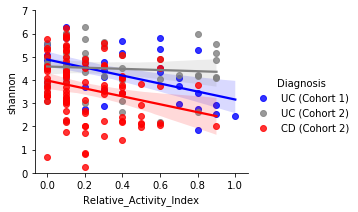

In [177]:
ax1 = sns.lmplot(x='Relative_Activity_Index', y = 'shannon', hue='Diagnosis', 
                 palette=['blue','gray','red'],ci=95,data = df_alpha,
                 truncate=True,height=3,aspect=1.25).set(ylim=(0, 7))
plt.savefig('./Shannon_ScatterbyActivity_CombinedDatasets.pdf', bbox_inches='tight')

In [161]:
model = smf.ols(formula='shannon ~ Relative_Activity_Index + Diagnosis + Relative_Activity_Index:Diagnosis', data=df_alpha).fit()
summary = model.summary()
summary.tables[0]

Dep. Variable:,shannon,R-squared:,0.189
Model:,OLS,Adj. R-squared:,0.167
Method:,Least Squares,F-statistic:,8.717
Date:,"Thu, 26 Mar 2020",Prob (F-statistic):,1.90e-07
Time:,12:25:12,Log-Likelihood:,-292.91
No. Observations:,193,AIC:,597.8
Df Residuals:,187,BIC:,617.4
Df Model:,5,,
Covariance Type:,nonrobust,,


In [174]:
Healthy = list(meta[meta['Diagnosis'] == 'Healthy_control'].index.astype('str'))
df_alpha_h = meta[meta.index.isin(Healthy)]

In [175]:
df_alpha_h = df_alpha_h[df_alpha_h['pielou_e'] != 'Missing']
df_alpha_h['pielou_e'] = df_alpha_h['pielou_e'].astype('float64')
df_alpha_h['observed_otus'] = df_alpha_h['observed_otus'].astype('float64')
df_alpha_h['shannon'] = df_alpha_h['shannon'].astype('float64')
df_alpha_h['faith_pd'] = df_alpha_h['faith_pd'].astype('float64')

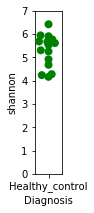

In [180]:
fig = plt.subplots(figsize=(0.5,3))
plot1 = sns.swarmplot(x='Diagnosis',y='shannon', palette=['g'],size=8, data=df_alpha_h)
plot1.set_ylim(0, 7)
plt.savefig('Healthy_shannon_swarm.pdf',bbox_inches="tight")

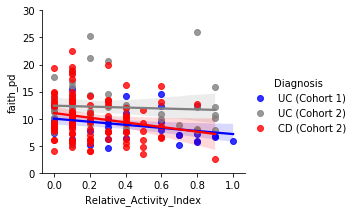

In [182]:
ax1 = sns.lmplot(x='Relative_Activity_Index', y = 'faith_pd', hue='Diagnosis', 
                 palette=['blue','gray','red'],ci=95,data = df_alpha,
                 truncate=True,height=3,aspect=1.25).set(ylim=(0, 30))
plt.savefig('./faithpd_ScatterbyActivity_CombinedDatasets.pdf', bbox_inches='tight')

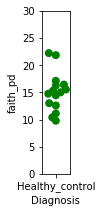

In [184]:
fig = plt.subplots(figsize=(0.5,3))
plot1 = sns.swarmplot(x='Diagnosis',y='faith_pd', palette=['g'],size=8, data=df_alpha_h)
plot1.set_ylim(0, 30)
plt.savefig('Healthy_faithpd_swarm.pdf',bbox_inches="tight")

In [163]:
model = smf.ols(formula='faith_pd ~ Relative_Activity_Index + Diagnosis + Relative_Activity_Index:Diagnosis', data=df_alpha).fit()
summary = model.summary()
summary.tables[0]

Dep. Variable:,faith_pd,R-squared:,0.113
Model:,OLS,Adj. R-squared:,0.089
Method:,Least Squares,F-statistic:,4.753
Date:,"Thu, 26 Mar 2020",Prob (F-statistic):,0.000412
Time:,12:26:12,Log-Likelihood:,-534.04
No. Observations:,193,AIC:,1080.
Df Residuals:,187,BIC:,1100.
Df Model:,5,,
Covariance Type:,nonrobust,,


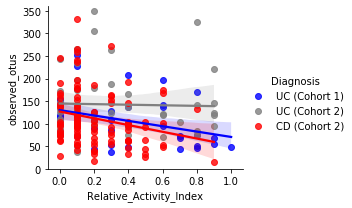

In [168]:
ax1 = sns.lmplot(x='Relative_Activity_Index', y = 'observed_otus', hue='Diagnosis', 
                 palette=['blue','gray','red'],ci=95,data = df_alpha,
                 truncate=True,height=3,aspect=1.25).set(ylim=(0, 360))
plt.savefig('./observedotus_ScatterbyActivity_CombinedDatasets.pdf', bbox_inches='tight')

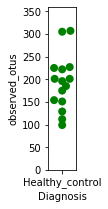

In [185]:
fig = plt.subplots(figsize=(0.5,3))
plot1 = sns.swarmplot(x='Diagnosis',y='observed_otus', palette=['g'],size=8, data=df_alpha_h)
plot1.set_ylim(0, 360)
plt.savefig('Healthy_observedotus_swarm.pdf',bbox_inches="tight")

In [166]:
model = smf.ols(formula='observed_otus ~ Relative_Activity_Index + Diagnosis + Relative_Activity_Index:Diagnosis', data=df_alpha).fit()
summary = model.summary()
summary.tables[0]

Dep. Variable:,observed_otus,R-squared:,0.098
Model:,OLS,Adj. R-squared:,0.074
Method:,Least Squares,F-statistic:,4.069
Date:,"Thu, 26 Mar 2020",Prob (F-statistic):,0.00158
Time:,12:26:49,Log-Likelihood:,-1066.5
No. Observations:,193,AIC:,2145.
Df Residuals:,187,BIC:,2165.
Df Model:,5,,
Covariance Type:,nonrobust,,


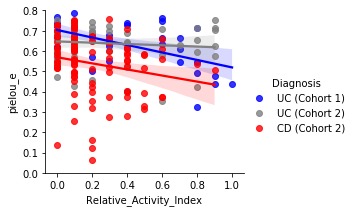

In [109]:
ax1 = sns.lmplot(x='Relative_Activity_Index', y = 'pielou_e', hue='Diagnosis', 
                 palette=['blue','gray','red'],ci=95,data = df_alpha,
                 truncate=True,height=3,aspect=1.25).set(ylim=(0, 0.8))
plt.savefig('./PielouE_ScatterbyActivity_CombinedDatasets.pdf', bbox_inches='tight')

In [33]:
Healthy = list(meta[meta['Diagnosis'] == 'Healthy_control'].index.astype('str'))
df_alpha_h = meta[meta.index.isin(Healthy)]

In [35]:

df_alpha_h = df_alpha_h[df_alpha_h['pielou_e'] != 'Missing']
df_alpha_h['pielou_e'] = df_alpha_h['pielou_e'].astype('float64')

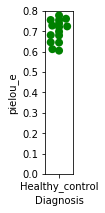

In [96]:
fig = plt.subplots(figsize=(0.5,3))
plot1 = sns.swarmplot(x='Diagnosis',y='pielou_e', palette=['g'],size=8, data=df_alpha_h)
plot1.set_ylim(0, 0.8)
plt.savefig('Healthy_pieloue_swarm.pdf',bbox_inches="tight")

In [120]:
df_alpha2 = df_alpha[df_alpha['Diagnosis'] != 'CD (Cohort 2)']

In [125]:
model = smf.ols(formula='pielou_e ~ Relative_Activity_Index + Diagnosis + Relative_Activity_Index:Diagnosis', data=df_alpha).fit()
summary = model.summary()
summary.tables[0]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,0.5695,0.019,30.687,0.000,0.533,0.606
Diagnosis[T.UC (Cohort 1)],0.1344,0.035,3.816,0.000,0.065,0.204
Diagnosis[T.UC (Cohort 2)],0.0779,0.030,2.624,0.009,0.019,0.136
Relative_Activity_Index,-0.1500,0.063,-2.368,0.019,-0.275,-0.025
Relative_Activity_Index:Diagnosis[T.UC (Cohort 1)],-0.0346,0.089,-0.389,0.698,-0.210,0.141
Relative_Activity_Index:Diagnosis[T.UC (Cohort 2)],0.1183,0.084,1.408,0.161,-0.047,0.284


### Taxa

##### previously run code records -- IBD200

!qiime feature-classifier classify-sklearn \
  --i-classifier ../gg-13-8-99-515-806-nb-classifier.qza \
  --i-reads sequences.qza \
  --o-classification taxonomy.qza

!qiime metadata tabulate \
  --m-input-file taxonomy.qza \
  --o-visualization taxonomy.qzv

!qiime taxa barplot \
  --i-table ./Biom_NoThaw.qza  \
  --i-taxonomy taxonomy.qza \
  --m-metadata-file ./metadata_16S_V1.txt \
  --o-visualization taxa-bar-plots-nothaw.qzv

##### previously run code records -- UC40

!qiime feature-classifier classify-sklearn \
  --i-classifier gg-13-8-99-515-806-nb-classifier.qza \
  --i-reads sequences.qza \
  --o-classification taxonomy.qza

!qiime metadata tabulate \
  --m-input-file taxonomy.qza \
  --o-visualization taxonomy.qzv

!qiime taxa barplot \
  --i-table biom_id2.qza \
  --i-taxonomy taxonomy.qza \
  --m-metadata-file UC_Severity_1_MF_Idswap6.21.18.txt \
  --o-visualization taxa-bar-plots_idswap2.qzv

### Dominant secies in low evenness samples plots

In [231]:
df = pd.read_csv('./16S/level-7-nothaw.csv', index_col = 'index')
df2 = pd.read_csv('./UC_40_level-7.csv', index_col = 'index')

In [232]:
meta = pd.read_csv('./Combined_Metadata_Allomics_16S_V1.txt', sep = '\t', index_col='#SampleID')
meta2 = pd.read_csv('../UC_Severity/UC_MP_Emperor_Map.txt',sep ='\t', index_col = 'id')
meta2['16s_SampleName'] = '11549.' + meta2.index.astype('str')
meta2.index = meta2['16s_SampleName']

In [233]:
meta = meta[meta['pielou_e'] != 'Missing']
meta['pielou_e'] = meta['pielou_e'].astype('float64')

In [234]:
#This line of code identifies low alpha-diversity samples in a new metadata column

low_even = []
for i in meta.index:
    if meta['pielou_e'][i] < 0.5:
        low_even.append('yes')
    else:
        low_even.append('no')
            

In [235]:
meta['low_evenness'] = low_even

In [236]:
#This line of code identifies low alpha-diversity samples in a new metadata column

low_even = []
for i in meta2.index:
    if meta2['pielou_e'][i] < 0.5:
        low_even.append('yes')
    else:
        low_even.append('no')
            

In [237]:
meta2['low_evenness'] = low_even

In [238]:
dfT = df.T
df2T = df2.T

In [239]:
Dominant_list = []
for i in df.index:
    dom_tax = dfT[i].sort_values(ascending=False).index[0]
    Dominant_list.append(dom_tax)

In [240]:
df['Abund_taxa'] = Dominant_list

In [241]:
Dominant_list = []
for i in df2.index:
    dom_tax = df2T[i].sort_values(ascending=False).index[0]
    Dominant_list.append(dom_tax)

In [242]:
df2['Abund_taxa'] = Dominant_list

In [243]:
#Blooms of enterobacter from a 24 hour thaw greatly effected this data, need to remove these samples
meta = meta[meta['Genomic_sample_underwent_24h_thaw'] != 'yes']
len(meta)

194

In [244]:
meta2 = meta2.merge(df2, left_index=True,right_index=True)
meta = meta.merge(df, left_index=True,right_index=True)

In [247]:
meta2['Diagnosis'] = 'UC'

In [248]:
interest_cols = ['Abund_taxa','low_evenness','Diagnosis']

In [249]:
meta2 = meta2[interest_cols]

,Abund_taxa,low_evenness,Diagnosis
11549.H1,k__Bacteria;p__Bacteroidetes;c__Bacteroidia;o_...,no,UC
11549.H10,k__Bacteria;p__Bacteroidetes;c__Bacteroidia;o_...,yes,UC
11549.H11,k__Bacteria;p__Proteobacteria;c__Gammaproteoba...,yes,UC
11549.H12,k__Bacteria;p__Firmicutes;c__Clostridia;o__Clo...,no,UC
11549.H13,k__Bacteria;p__Firmicutes;c__Clostridia;o__Clo...,no,UC
11549.H14,k__Bacteria;p__Firmicutes;c__Clostridia;o__Clo...,no,UC
11549.H15,k__Bacteria;p__Bacteroidetes;c__Bacteroidia;o_...,no,UC
11549.H16,k__Bacteria;p__Firmicutes;c__Clostridia;o__Clo...,no,UC
11549.H17,k__Bacteria;p__Bacteroidetes;c__Bacteroidia;o_...,no,UC
11549.H18,k__Bacteria;p__Bacteroidetes;c__Bacteroidia;o_...,no,UC


In [250]:
meta = meta[interest_cols]

In [252]:
meta_combined = pd.concat([meta,meta2])

In [254]:
meta_combined_counts = meta_combined.groupby(interest_cols).size().reset_index(name='count')

In [255]:
priority_of_cols = ['Diagnosis','low_evenness','count']
meta_combined_counts = meta_combined_counts.sort_values(by = priority_of_cols)

In [256]:
meta_combined_counts.to_csv('./Counts_ofMostabundant_by_Diagnosisand05Evenness_UC40combined.csv')

In [265]:
# Make data: I have 3 groups and 7 subgroups
group_names=['Low Evenness CD', 'High Evenness CD','Low Evenness UC', 'High Evenness UC','Healthy Controls']

group_size=[38,82,11,84,15]

subgroup_names=['f__Enterobacteriaceae;__', 'Others', 'g__Akkermansia;s__muciniphila', 
                
                'Others', 'f__Enterobacteriaceae;__', 
                'g__Bacteroides;s__', 'g__Faecalibacterium;s__prausnitzii','g__Blautia;s__',
                
                
                'Others','g__Bacteroides;s__',
                
                
                'Others','g__Faecalibacterium;s__prausnitzii','g__Bacteroides;s__', 'g__Blautia;s__','g__Bifidobacterium;__',
                
               'g__Faecalibacterium;s__prausnitzii','Others']
subgroup_size=[25,8,5,  36,17,12,10,7,  8,3,  29,19,19,10,7,  9,6]



In [266]:
# Create colors
a, b, c, d, e=[plt.cm.Reds, plt.cm.Oranges, plt.cm.Blues, plt.cm.Purples, plt.cm.Greens]

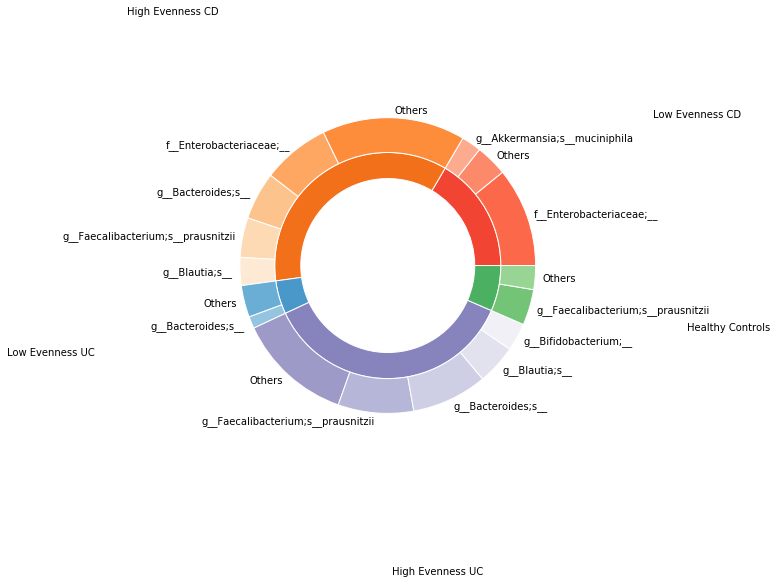

In [268]:
# First Ring (outside)
fig, ax = plt.subplots()
ax.axis('equal')
mypie, _ = ax.pie(group_size, radius=1.3,labeldistance=2.7, labels=group_names, colors=[a(0.6), b(0.6), c(0.6), d(0.6), e(0.6)] )
plt.setp(mypie, width=0.3, edgecolor='white')

# Second Ring (Inside)
mypie2, _ = ax.pie(subgroup_size, radius=1.7, labels=subgroup_names, labeldistance=1.05, colors=[a(0.5), a(0.4), a(0.3), 
                                                                                                    b(0.5), b(0.4), b(0.3), b(0.2), b(0.1),
                                                                                                    c(0.5),c(0.4),
                                                                                                    d(0.5), d(0.4),d(0.3),d(0.2),d(0.1),
                                                                                                    e(0.5),e(0.4)])
plt.setp( mypie2, width=0.4, edgecolor='white')
plt.margins(0,0)

plt.savefig('./Donuts_MostAbundantASV_byDiagnosisANDEvenness_datasetscombined.pdf',bbox_inches='tight')
plt.show()

### 16S taxonomic bar charts

In [6]:
meta = pd.read_csv('./Combined_Metadata_Allomics_16S_V1.txt', sep = '\t', index_col='id')
meta2 = pd.read_csv('../UC_Severity/UC_MP_Emperor_Map.txt',sep ='\t', index_col = 'id')
meta2['16s_SampleName'] = '11549.' + meta2.index.astype('str')
meta2.index = meta2['16s_SampleName']

In [7]:
Activity_cat=[]
for i in meta2['partial_Mayo']:
    try:
        a = float(i)
        if a < 3:
            Activity_cat.append('Low')
        elif a <6:
            Activity_cat.append('Moderate')
        elif a <11:
            Activity_cat.append('High')
        else:
            Activity_cat.append('not applicable')
    except ValueError:
        Activity_cat.append('not applicable')
    
meta2['Activity_Level'] = Activity_cat

In [8]:
#df = pd.read_csv('./16S/level-6-nothaw.csv', index_col = 'index').T
df = pd.read_csv('./16S/level-2-nothaw.csv', index_col = 'index').T

#df2 = pd.read_csv('./UC_40_level-6.csv', index_col = 'index').T
df2 = pd.read_csv('./UC_40_level-2.csv', index_col = 'index').T

In [9]:
meta = meta.sort_values('Relative_Activity')
meta['Sample_with_Activity'] = meta.index + ' (' + meta['Relative_Activity'].astype('str') + ')'

In [10]:
#make separate metadata for healthy patients because they won't have activity
meta3 = meta[meta["Relative_Activity"] != 'Missing']

In [11]:
UC_patients = list(meta3[meta3['Diagnosis'] == 'UC'].index)
Healthy_controls = list(meta[meta['Diagnosis'] == 'Healthy_control'].index)
Colonic_CD = list(meta3[(meta3['Diagnosis'] == 'CD') & (meta3['Location'] == 'Colonic')].index)
Ileal_CD = list(meta3[(meta3['Diagnosis'] == 'CD') & (meta3['Location'] == 'Ileal')].index)
Ileocolonic_CD = list(meta3[(meta3['Diagnosis'] == 'CD') & (meta3['Location'] == 'Ileocolonic')].index)

In [12]:
#Remove samples missing from the original dataframe
UC_patients = list(set(UC_patients) & set(df.columns))
Healthy_controls = list(set(Healthy_controls) & set(df.columns))
Colonic_CD = list(set(Colonic_CD) & set(df.columns))
Ileal_CD = list(set(Ileal_CD) & set(df.columns))
Ileocolonic_CD = list(set(Ileocolonic_CD) & set(df.columns))

In [13]:
#Resort the samples by the activity index
UC_patients=list(meta.loc[UC_patients].sort_values('Relative_Activity_Index').index)
Colonic_CD=list(meta.loc[Colonic_CD].sort_values('Relative_Activity_Index').index)
Ileal_CD=list(meta.loc[Ileal_CD].sort_values('Relative_Activity_Index').index)
Ileocolonic_CD=list(meta.loc[Ileocolonic_CD].sort_values('Relative_Activity_Index').index)

In [14]:
UC_Cohort1 = list(meta2.sort_values('Relative_Activity_Index').index)

In [15]:
#Combine both datasets
df_merge = df.merge(df2, left_index=True,right_index=True, how='outer')
df_merge.replace(np.nan,0,inplace=True)

In [16]:
lists = [Healthy_controls,UC_Cohort1,UC_patients,Colonic_CD,Ileocolonic_CD,Ileal_CD]

In [17]:
#df_merge['Genus'] = df_merge.index
df_merge['Phylum'] = df_merge.index

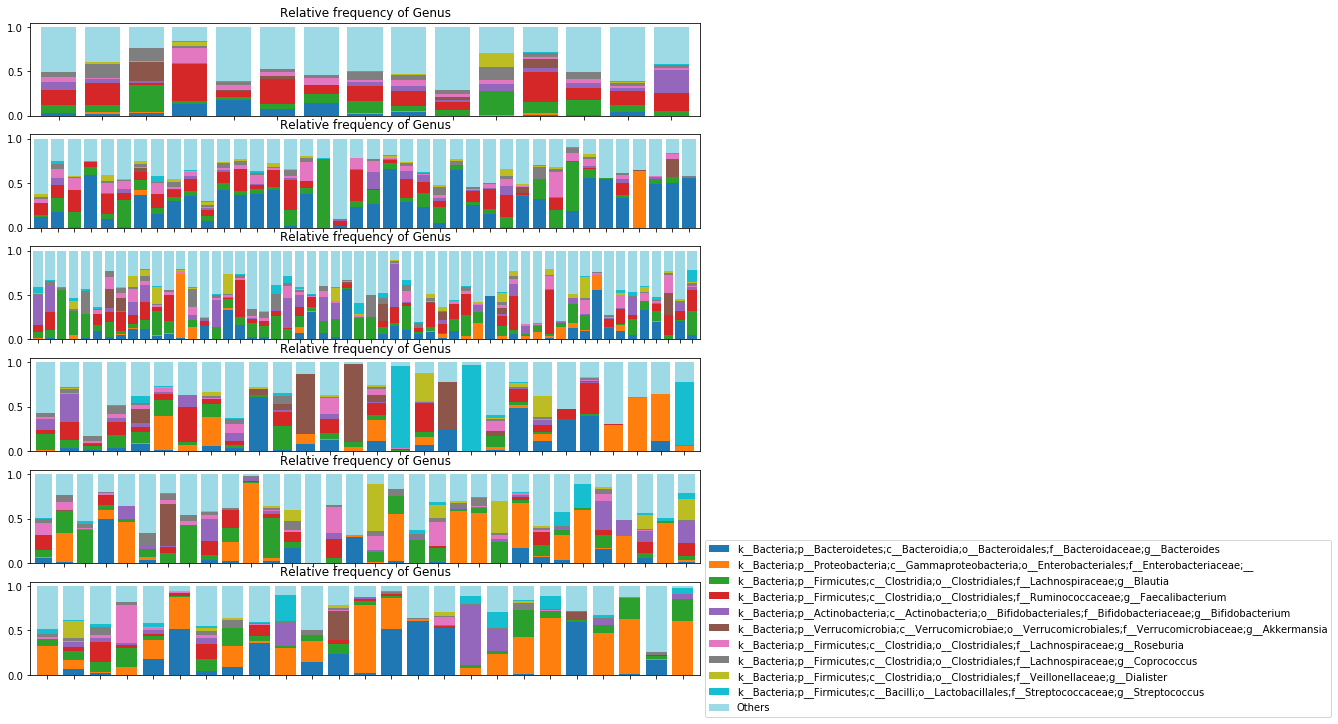

In [307]:
#Display from genera results
PlotBy_MultiSampleGroups(df=df_merge,lists=lists,Taxa_col='Genus',display_number=10,save_descrip='Bothdatasets_16S_genera_comp_Diagnosis_Location_Activity_top10',human="True")

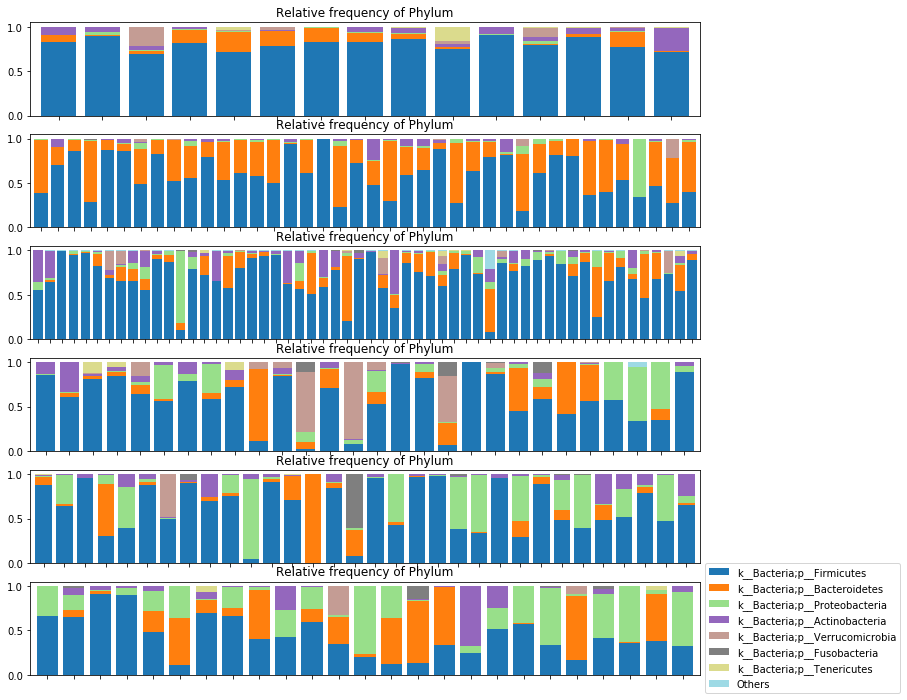

In [312]:
#Display from genera results
PlotBy_MultiSampleGroups(df=df_merge,lists=lists,Taxa_col='Phylum',display_number=7,save_descrip='Bothdatasets_16S_phylum_comp_Diagnosis_Location_Activity_top7',human="True")

#### Metaproteome bar plot

##### Average each sample by the severity of disease

In [19]:
#Combine both dataset metadata files
combined_meta = pd.concat([meta2,meta3],join='inner')

In [20]:
lists = [UC_Cohort1,UC_patients,Colonic_CD,Ileocolonic_CD,Ileal_CD]

In [21]:
col_order=['Low','Moderate','High']

/Users/rhmills/miniconda3/envs/qiime2-2019.7/lib/python3.6/site-packages/ipykernel_launcher.py:114: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


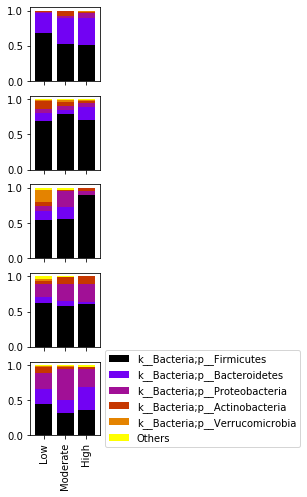

In [45]:
PlotByCategory_MultiSampleGroups(df=df_merge,lists=lists,Taxa_col='Phylum',category='Activity_Level',metadata=combined_meta,display_number=5,save_descrip='Bothdatasets_16S_phylum_comp_Diagnosis_Location_ActivityLevel_top6_axis',
                                 human="True",col_order=col_order)

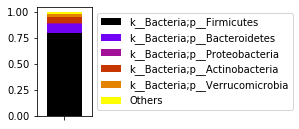

In [54]:
#Note taking the global out put of Others & top_list for keeping consistent column colors between these two plots

PlotByCategory(df=df_merge,lists=Healthy_controls,Taxa_col='Phylum',
               category='Relative_Activity_Index',
               metadata=combined_meta,display_number=5,
               save_descrip='16S_phylum_comp_HealthyAveraged_top5',
               human="True",top_taxa=False,Others=Others,top_list=top_list)

/Users/rhmills/miniconda3/envs/qiime2-2019.7/lib/python3.6/site-packages/ipykernel_launcher.py:114: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


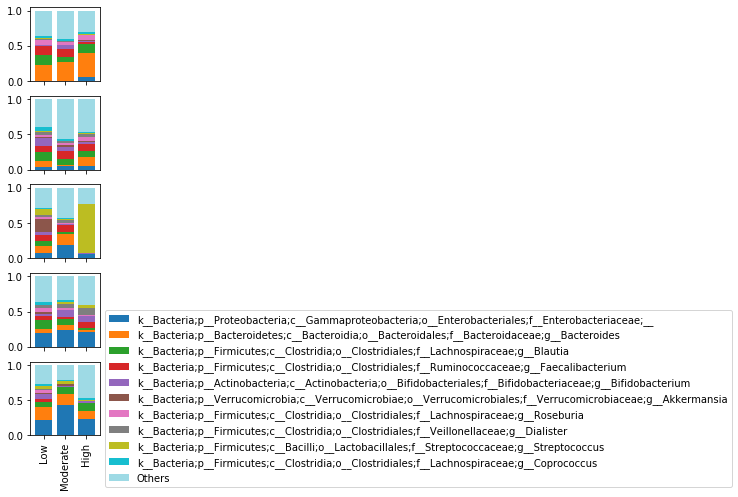

In [357]:
PlotByCategory_MultiSampleGroups(df=df_merge,lists=lists,Taxa_col='Genus',category='Activity_Level',metadata=combined_meta,display_number=10,save_descrip='Bothdatasets_16S_genus_comp_Diagnosis_Location_ActivityLevel_top10',
                                 human="True",col_order=col_order)

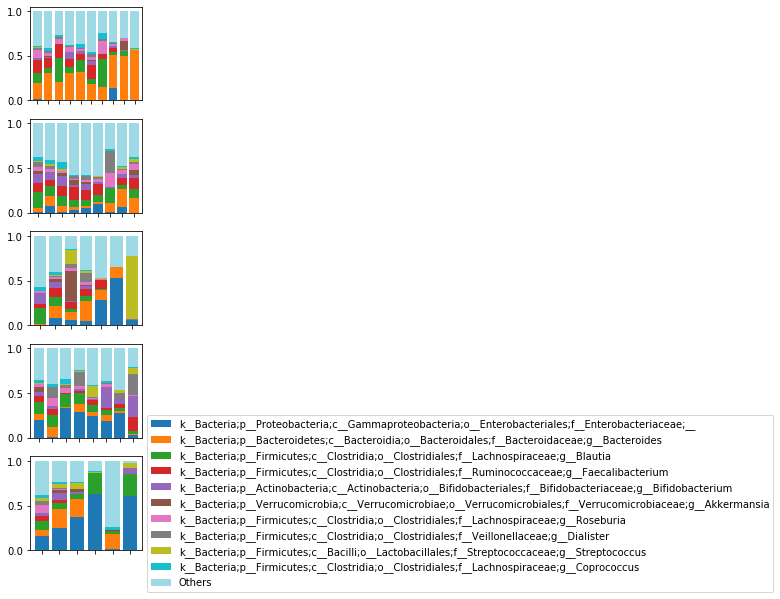

In [399]:
PlotByCategory_MultiSampleGroups(df=df_merge,lists=lists,Taxa_col='Genus',category='Relative_Activity_Index',metadata=combined_meta,display_number=10,save_descrip='Bothdatasets_16S_genus_comp_Diagnosis_Location_ActivityAveraged_top10',human="True")

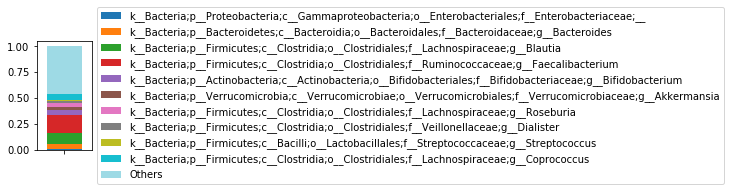

In [404]:
PlotByCategory(df=df_merge,lists=Healthy_controls,Taxa_col='Genus',category='Relative_Activity_Index',metadata=combined_meta,display_number=10,save_descrip='16S_genus_comp_HealthyAveraged_top10',human="True",top_taxa=False)

### Random forest models of UC Severity

##### Create a combined table to confirm this doesn't improve accuracy

In [21]:
meta = pd.read_csv('./Combined_metadata_inallomics_nonredundant.txt', sep='\t')

In [22]:
meta.index = meta['Proteome_ID'].astype('str')

In [23]:
shared=list(meta['#SampleID'].astype('str'))

In [255]:
df = pd.read_csv('./IBD200_MGDBFinal_Normalized_common_qiime.txt',sep='\t',index_col='#OTU ID')
df2 = df.T.merge(meta,left_index=True,right_index=True)
features = list(df.index)
df2.rename(columns={'id':'#OTU ID'}, inplace=True)
df2.index = df2['#OTU ID']
df2=df2.T
df2 = df2.loc[features]
df2.columns = df2.columns.astype('str')
df2 = df2[shared]
df2.to_csv('./MP_CommonSamples_tubeid.txt',sep = '\t')

In [35]:
#Version 2 metabolomics: 

meta.index = meta['Metabolomics_FileName'].astype('str')

df = pd.read_csv('./Metabolomics/MB_Standardized_Table_Normalized.txt',
                 sep='\t')
df.rename(columns={'#OTUID':'features'},inplace=True)
df.index = df['features']
df2 = df.T.merge(meta,left_index=True,right_index=True)
features = list(df.index)
df2.rename(columns={'#SampleID':'#OTUID'}, inplace=True)
df2.index = df2['#OTUID']
df2=df2.T
df2 = df2.loc[features]
df2.columns = df2.columns.astype('str')
df2 = df2[shared]
df2.to_csv('./MB_CommonSamples_tubeid2.txt',sep = '\t')

In [7]:
df = pd.read_csv('./Metabolomics_QemistreeMergedTable.txt',
                 sep='\t')

In [257]:
meta.index = meta['16S_id'].astype('str')

df = pd.read_csv('./MetaG_gOTU_table.txt',
                 sep='\t')
df.rename(columns={'#OTU ID':'features'},inplace=True)
df.index = df['features']
df2 = df.T.merge(meta,left_index=True,right_index=True)
features = list(df.index)
df2.rename(columns={'id':'#OTU ID'}, inplace=True)
df2.index = df2['#OTU ID']
df2=df2.T
df2 = df2.loc[features]
df2.columns = df2.columns.astype('str')
df2 = df2[shared]
df2.to_csv('./MG_CommonSamples_tubeid.txt',sep = '\t')

In [226]:
#Convert biom file to tab seperated
!biom convert -i ./16S/80086_reference-hit.biom \
-o ./16S_table.txt \
--to-tsv

In [233]:
List16S = list(set(shared) - set(df2.columns))

In [259]:
meta.index = meta['16S_id'].astype('str')

df = pd.read_csv('./16S_table.txt',
                 sep='\t')
df.rename(columns={'#OTU ID':'features'},inplace=True)
df.index = df['features']
df2 = df.T.merge(meta,left_index=True,right_index=True)
features = list(df.index)
df2.rename(columns={'id':'#OTU ID'}, inplace=True)
df2.index = df2['#OTU ID']
df2=df2.T
df2 = df2.loc[features]
df2.columns = df2.columns.astype('str')
df2 = df2[shared]
df2.to_csv('./16S_CommonSamples_tubeid.txt',sep = '\t')

In [5]:
#Combine all dataframes into a shared dataframe:
MG = pd.read_csv('./MG_CommonSamples_tubeid.txt',sep='\t',index_col=0)
Amp= pd.read_csv('./16S_CommonSamples_tubeid.txt', sep='\t',index_col=0)
MP = pd.read_csv('./MP_CommonSamples_tubeid.txt',sep='\t',index_col=0)
MB = pd.read_csv('./MB_CommonSamples_tubeid2.txt',sep='\t',index_col=0)

In [43]:
combined_df = pd.concat([MG,Amp,MP,MB])

In [44]:
combined_df.index.rename('#OTU ID', inplace=True)

In [45]:
combined_df.to_csv('./IBD200_SharedSamples_AllOmicsCombined2.txt',sep='\t')

In [48]:
meta = pd.read_csv('./Combined_metadata_inallomics_nonredundant.txt',sep='\t',index_col='#SampleID')

In [49]:
#Convert tab-separated file to biom file
!biom convert -i ./IBD200_SharedSamples_AllOmicsCombined2.txt \
-o ./IB200_SharedSamples_AllOmicsCombined2.biom \
-m ./Combined_metadata_inallomics_nonredundant.txt \
--table-type="OTU table" --to-hdf5

In [50]:
!qiime tools import \
  --input-path ./IB200_SharedSamples_AllOmicsCombined2.biom \
  --type 'FeatureTable[Frequency]' \
  --output-path ./IBD200_SharedSamples_AllOmicsCombined2.qza

Imported ./IB200_SharedSamples_AllOmicsCombined2.biom as BIOMV210DirFmt to ./IBD200_SharedSamples_AllOmicsCombined2.qza


In [23]:
meta = pd.read_csv('./Combined_metadata_inallomics_nonredundant.txt', sep = '\t',index_col='#SampleID')

cols = ['partial_Mayo','Relative_Activity','Diagnosis']
meta = meta[meta['Diagnosis'] == 'UC']
meta['partial_Mayo'] = meta['partial_Mayo'].astype('float')
meta['Relative_Activity'] = meta['Relative_Activity'].astype('float')
meta = meta[cols]
meta.to_csv('./Combined_metadata_inallomics_nonredundan_UCfiltered.txt', sep = '\t')


In [51]:
## filter table 

!qiime feature-table filter-samples \
  --i-table ./IBD200_SharedSamples_AllOmicsCombined2.qza \
  --m-metadata-file ./Combined_metadata_inallomics_nonredundan_UCfiltered.txt \
  --p-where "Diagnosis=='UC'" \
  --o-filtered-table ./IBD200_SharedSamples_AllOmicsCombined_UCfilteredtable2.qza

Saved FeatureTable[Frequency] to: ./IBD200_SharedSamples_AllOmicsCombined_UCfilteredtable2.qza


Performed iterative random forests on the supercomputer

### Compare beta-diversity distributions between data types in cohort 2

In [29]:
%matplotlib inline
import qiime2 as q2
import seaborn as sns, numpy as np
from skbio import DistanceMatrix
from skbio.stats.distance import mantel
import pandas as pd

In [68]:
meta2 = pd.read_csv('./Combined_metadata_inallomics_nonredundant.txt',sep='\t')
inall=list(meta2['#SampleID'])

In [117]:
#Update metadata to include UC histology data:
meta = pd.read_csv('./Combined_metadata_allomics_hist.txt',sep='\t')
meta['#SampleID']=meta['tube_id']
meta.index = meta['#SampleID']
meta=meta[meta.index!='not applicable']
meta=meta.drop_duplicates(subset='tube_id')
meta=meta[meta.index.isin(inall)]
meta=meta.drop(columns='#SampleID')
meta=meta.rename(columns={'sample-id':'16S_samplename'})
meta=meta.drop(columns='Activity_Level')
meta.to_csv('./Combined_metadata_inallomics_hist.txt',sep='\t')

In [7]:
#Convert tab-separated file to biom file
!biom convert -i ./MG_CommonSamples_tubeid_Qiime.txt \
-o ./MG_CommonSamples_tubeid.biom \
-m ./Combined_metadata_inallomics_nonredundant.txt \
--table-type="OTU table" --to-hdf5

In [8]:
#Convert tab-separated file to biom file
!biom convert -i ./16S_CommonSamples_tubeid_Qiime.txt \
-o ./16S_CommonSamples_tubeid.biom \
-m ./Combined_metadata_inallomics_nonredundant.txt \
--table-type="OTU table" --to-hdf5

In [9]:
#Convert tab-separated file to biom file
!biom convert -i ./MB_CommonSamples_tubeid2_Qiime.txt \
-o ./MB_CommonSamples_tubeid.biom \
-m ./Combined_metadata_inallomics_nonredundant.txt \
--table-type="OTU table" --to-hdf5

In [10]:
#Convert tab-separated file to biom file
!biom convert -i ./MP_CommonSamples_tubeid_Qiime.txt \
-o ./MP_CommonSamples_tubeid.biom \
-m ./Combined_metadata_inallomics_nonredundant.txt \
--table-type="OTU table" --to-hdf5

In [11]:
!qiime tools import \
  --input-path ./MG_CommonSamples_tubeid.biom \
  --type 'FeatureTable[Frequency]' \
  --output-path ./MG_CommonSamples_tubeid.qza

Imported ./MG_CommonSamples_tubeid.biom as BIOMV210DirFmt to ./MG_CommonSamples_tubeid.qza


In [12]:
!qiime tools import \
  --input-path ./16S_CommonSamples_tubeid.biom \
  --type 'FeatureTable[Frequency]' \
  --output-path 16S_CommonSamples_tubeid.qza

Imported ./16S_CommonSamples_tubeid.biom as BIOMV210DirFmt to 16S_CommonSamples_tubeid.qza


In [13]:
!qiime tools import \
  --input-path ./MB_CommonSamples_tubeid.biom \
  --type 'FeatureTable[Frequency]' \
  --output-path MB_CommonSamples_tubeid.qza

Imported ./MB_CommonSamples_tubeid.biom as BIOMV210DirFmt to MB_CommonSamples_tubeid.qza


In [14]:
!qiime tools import \
  --input-path ./MP_CommonSamples_tubeid.biom \
  --type 'FeatureTable[Frequency]' \
  --output-path ./MP_CommonSamples_tubeid.qza

Imported ./MP_CommonSamples_tubeid.biom as BIOMV210DirFmt to ./MP_CommonSamples_tubeid.qza


In [87]:
!qiime feature-table summarize \
  --i-table ./MG_CommonSamples_tubeid.qza \
  --o-visualization ./MG_CommonSamples_tubeid.qzv \
  --m-sample-metadata-file ./Combined_metadata_inallomics_hist.txt

Saved Visualization to: ./MG_CommonSamples_tubeid.qzv


In [16]:
!qiime feature-table summarize \
  --i-table ./16S_CommonSamples_tubeid.qza \
  --o-visualization ./16S_CommonSamples_tubeid.qzv \
  --m-sample-metadata-file ./Combined_metadata_inallomics_nonredundant.txt

Saved Visualization to: ./16S_CommonSamples_tubeid.qzv


In [17]:
!qiime feature-table summarize \
  --i-table ./MB_CommonSamples_tubeid.qza \
  --o-visualization ./MB_CommonSamples_tubeid.qzv \
  --m-sample-metadata-file ./Combined_metadata_inallomics_nonredundant.txt

Saved Visualization to: ./MB_CommonSamples_tubeid.qzv


In [18]:
!qiime feature-table summarize \
  --i-table ./MP_CommonSamples_tubeid.qza \
  --o-visualization ./MP_CommonSamples_tubeid.qzv \
  --m-sample-metadata-file ./Combined_metadata_inallomics_nonredundant.txt

Saved Visualization to: ./MP_CommonSamples_tubeid.qzv


In [88]:
#Core metrics for PCoA 
!qiime diversity core-metrics \
--i-table ./MG_CommonSamples_tubeid.qza \
--p-sampling-depth 500000 \
--m-metadata-file ./Combined_metadata_inallomics_hist.txt \
--output-dir core-metrics-results-MG-allomics2

Saved FeatureTable[Frequency] to: core-metrics-results-MG-allomics2/rarefied_table.qza
Saved SampleData[AlphaDiversity] to: core-metrics-results-MG-allomics2/observed_otus_vector.qza
Saved SampleData[AlphaDiversity] to: core-metrics-results-MG-allomics2/shannon_vector.qza
Saved SampleData[AlphaDiversity] to: core-metrics-results-MG-allomics2/evenness_vector.qza
Saved DistanceMatrix to: core-metrics-results-MG-allomics2/jaccard_distance_matrix.qza
Saved DistanceMatrix to: core-metrics-results-MG-allomics2/bray_curtis_distance_matrix.qza
Saved PCoAResults to: core-metrics-results-MG-allomics2/jaccard_pcoa_results.qza
Saved PCoAResults to: core-metrics-results-MG-allomics2/bray_curtis_pcoa_results.qza
Saved Visualization to: core-metrics-results-MG-allomics2/jaccard_emperor.qzv
Saved Visualization to: core-metrics-results-MG-allomics2/bray_curtis_emperor.qzv


In [92]:
#Core metrics for PCoA 
!qiime diversity core-metrics \
--i-table ./16S_CommonSamples_tubeid.qza \
--p-sampling-depth 6219 \
--m-metadata-file ./Combined_metadata_inallomics_hist.txt \
--output-dir core-metrics-results-16S-allomics2

Saved FeatureTable[Frequency] to: core-metrics-results-16S-allomics2/rarefied_table.qza
Saved SampleData[AlphaDiversity] to: core-metrics-results-16S-allomics2/observed_otus_vector.qza
Saved SampleData[AlphaDiversity] to: core-metrics-results-16S-allomics2/shannon_vector.qza
Saved SampleData[AlphaDiversity] to: core-metrics-results-16S-allomics2/evenness_vector.qza
Saved DistanceMatrix to: core-metrics-results-16S-allomics2/jaccard_distance_matrix.qza
Saved DistanceMatrix to: core-metrics-results-16S-allomics2/bray_curtis_distance_matrix.qza
Saved PCoAResults to: core-metrics-results-16S-allomics2/jaccard_pcoa_results.qza
Saved PCoAResults to: core-metrics-results-16S-allomics2/bray_curtis_pcoa_results.qza
Saved Visualization to: core-metrics-results-16S-allomics2/jaccard_emperor.qzv
Saved Visualization to: core-metrics-results-16S-allomics2/bray_curtis_emperor.qzv


In [93]:
#Core metrics for PCoA 
!qiime diversity core-metrics \
--i-table ./MB_CommonSamples_tubeid.qza \
--p-sampling-depth 968859 \
--m-metadata-file ./Combined_metadata_inallomics_hist.txt \
--output-dir core-metrics-results-MB-allomics2

Saved FeatureTable[Frequency] to: core-metrics-results-MB-allomics2/rarefied_table.qza
Saved SampleData[AlphaDiversity] to: core-metrics-results-MB-allomics2/observed_otus_vector.qza
Saved SampleData[AlphaDiversity] to: core-metrics-results-MB-allomics2/shannon_vector.qza
Saved SampleData[AlphaDiversity] to: core-metrics-results-MB-allomics2/evenness_vector.qza
Saved DistanceMatrix to: core-metrics-results-MB-allomics2/jaccard_distance_matrix.qza
Saved DistanceMatrix to: core-metrics-results-MB-allomics2/bray_curtis_distance_matrix.qza
Saved PCoAResults to: core-metrics-results-MB-allomics2/jaccard_pcoa_results.qza
Saved PCoAResults to: core-metrics-results-MB-allomics2/bray_curtis_pcoa_results.qza
Saved Visualization to: core-metrics-results-MB-allomics2/jaccard_emperor.qzv
Saved Visualization to: core-metrics-results-MB-allomics2/bray_curtis_emperor.qzv


In [94]:
#Core metrics for PCoA 
!qiime diversity core-metrics \
--i-table ./MP_CommonSamples_tubeid.qza \
--p-sampling-depth 151343 \
--m-metadata-file ./Combined_metadata_inallomics_hist.txt \
--output-dir core-metrics-results-MP-allomics2

Saved FeatureTable[Frequency] to: core-metrics-results-MP-allomics2/rarefied_table.qza
Saved SampleData[AlphaDiversity] to: core-metrics-results-MP-allomics2/observed_otus_vector.qza
Saved SampleData[AlphaDiversity] to: core-metrics-results-MP-allomics2/shannon_vector.qza
Saved SampleData[AlphaDiversity] to: core-metrics-results-MP-allomics2/evenness_vector.qza
Saved DistanceMatrix to: core-metrics-results-MP-allomics2/jaccard_distance_matrix.qza
Saved DistanceMatrix to: core-metrics-results-MP-allomics2/bray_curtis_distance_matrix.qza
Saved PCoAResults to: core-metrics-results-MP-allomics2/jaccard_pcoa_results.qza
Saved PCoAResults to: core-metrics-results-MP-allomics2/bray_curtis_pcoa_results.qza
Saved Visualization to: core-metrics-results-MP-allomics2/jaccard_emperor.qzv
Saved Visualization to: core-metrics-results-MP-allomics2/bray_curtis_emperor.qzv


In [36]:
PREPS = {
    'Metabolomics': 'core-metrics-results-MB-allomics/bray_curtis_distance_matrix.qza',
    'Metaproteomics': 'core-metrics-results-MP-allomics/bray_curtis_distance_matrix.qza',
    'Metagenomics': 'core-metrics-results-MG-allomics/bray_curtis_distance_matrix.qza',    
    '16S':'core-metrics-results-16S-allomics/bray_curtis_distance_matrix.qza'
}

In [37]:
dms = {}
for prep, path in PREPS.items():
    dms[prep] = q2.Artifact.load(path).view(DistanceMatrix)
    
# fix the sample ids for the 16S
#dms['16S'].ids = [i.replace('11549.', '') for i in dms['16S'].ids]

corr = pd.DataFrame(columns=dms.keys(), index=dms.keys(), dtype=np.float)

In [38]:
#Several samples were removed from MG and 16S due to rarefaction fix here
shared = set()
for prep, dm in dms.items():
    if len(shared) == 0:
        shared = set(dm.ids)
    else:
        shared &= set(dm.ids)

dms = {prep: dm.filter(shared) for prep, dm in  dms.items()}

In [39]:
from itertools import combinations

for prep_a, prep_b in combinations(dms.keys(), 2):
    r, p, n = mantel(dms[prep_a], dms[prep_b])
    
    corr.loc[prep_a, prep_b] = r
    corr.loc[prep_b, prep_a] = r

In [40]:
corr = corr.sort_values(by = ['Metabolomics', 'Metagenomics', 'Metaproteomics', '16S'])
corr = corr.sort_values(by = ['Metabolomics', 'Metagenomics', 'Metaproteomics', '16S'], axis = 1)

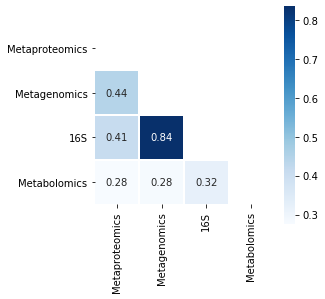

In [195]:
# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True


# Draw the heatmap with the mask and correct aspect ratio 
ax=plt.subplots(figsize=(4,4))
ax = sns.heatmap(corr, mask=mask, cmap='Blues', annot = True,
            square=True, linewidths=.5)
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)
plt.savefig('./IBD200metaomics_CorrHeatmap_BrayCurtisMGs_Blues.pdf')

##### Identify the correlations between metadata variables, alpha and beta-diversity metrics in second cohort

In [ ]:
Categorical=['ASA_Exposure','Biologic_Exposure',
             'Biologic_Exposure_Type_IFX1_ADA2_GOL3_VDZ4_SIM5_UST6_TOF7',
             'Current_5ASA','Current_Antidepressents','Current_Biologic','Current_Biologic_Type_IFX1_ADA2_GOL3_VDZ4_SIM5_UST6_TOF7',
            'Current_IM','Current_IM_Type_1AZA_26MP_3MTX','Current_Steroids','Current_Steroids','Historic_Extent',
             'IM_Exposure','IM_Exposure_Type_1AZA_26MP_3MTX','Smoker','Steroid_Exposure']
Quantitative=['PGA','Rectal_Bleeding','Mayo_Endoscopic_Score','UCEIS','partial_Mayo']

In [118]:
## filter table 
!qiime feature-table filter-samples \
  --i-table ./MP_CommonSamples_tubeid.qza \
  --m-metadata-file ./Combined_metadata_inallomics_hist.txt \
  --p-where "Diagnosis=='UC'" \
  --o-filtered-table ./MP_CommonSamples_tubeid_UC.qza

Saved FeatureTable[Frequency] to: ./MP_CommonSamples_tubeid_UC.qza


In [119]:
## filter table 
!qiime feature-table filter-samples \
  --i-table ./MB_CommonSamples_tubeid.qza \
  --m-metadata-file ./Combined_metadata_inallomics_hist.txt \
  --p-where "Diagnosis=='UC'" \
  --o-filtered-table ./MB_CommonSamples_tubeid_UC.qza

Saved FeatureTable[Frequency] to: ./MB_CommonSamples_tubeid_UC.qza


In [120]:
## filter table 
!qiime feature-table filter-samples \
  --i-table ./16S_CommonSamples_tubeid.qza \
  --m-metadata-file ./Combined_metadata_inallomics_hist.txt \
  --p-where "Diagnosis=='UC'" \
  --o-filtered-table ./16S_CommonSamples_tubeid_UC.qza

Saved FeatureTable[Frequency] to: ./16S_CommonSamples_tubeid_UC.qza


In [121]:
## filter table 
!qiime feature-table filter-samples \
  --i-table ./MG_CommonSamples_tubeid.qza \
  --m-metadata-file ./Combined_metadata_inallomics_hist.txt \
  --p-where "Diagnosis=='UC'" \
  --o-filtered-table ./MG_CommonSamples_tubeid_UC.qza

Saved FeatureTable[Frequency] to: ./MG_CommonSamples_tubeid_UC.qza


In [123]:
artifact_feat = q2.Artifact.load('./MG_CommonSamples_tubeid_UC.qza')
artifact_feat.export_data('./MG_CommonSamples_tubeid_UC')

In [124]:
artifact_feat = q2.Artifact.load('./MB_CommonSamples_tubeid_UC.qza')
artifact_feat.export_data('./MB_CommonSamples_tubeid_UC')

In [125]:
artifact_feat = q2.Artifact.load('./MP_CommonSamples_tubeid_UC.qza')
artifact_feat.export_data('./MP_CommonSamples_tubeid_UC')

In [126]:
artifact_feat = q2.Artifact.load('./16S_CommonSamples_tubeid_UC.qza')
artifact_feat.export_data('./16S_CommonSamples_tubeid_UC')

In [134]:
df2=pd.read_csv('./Combined_metadata_inallomics_hist_UC_quantitative.txt',sep='\t')
df=pd.read_csv('./Combined_metadata_inallomics_hist.txt',sep='\t')
allquant=list(df2['#SampleID'])
HasQuant=[]
for i in df['#SampleID']:
    if i in allquant:
        HasQuant.append('yes')
    else:
        HasQuant.append('no')

In [144]:
df['Has_All_UC_Quantitative_Variables']=HasQuant
df.index=df['#SampleID']
df=df.drop(columns='#SampleID')
df.to_csv('./Combined_metadata_inallomics_hist2.txt',sep='\t')

,Unnamed: 0,Unnamed: 0.1,tube_id,Metagenomics_sequencing_name,Sample_name,Patient_ID,SubjectID,host_subject_id,Metabolomics_FileName,Metabolomics_FileName_Run1,...,Geboes_Grade_5,Comment,Geboes_Grade_0_Numeric,Geboes_Grade_0_Numeric.1,Geboes_Grade_2A_Numeric,Geboes_Grade_2B_Numeric,Geboes_Grade_3_Numeric,Geboes_Grade_4_Numeric,Geboes_Grade_5_Numeric,Has_All_UC_Quantitative_Variables
#SampleID,,,,,,,,,,,,,,,,,,,,,
107212,0,0,107212,107212_S702,107212,HC1,Healthy_control,HC1,000107212_BA6_01_52101.mzXML,000107212_BA6_01_50296.mzXML,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,no
107213,1,1,107213,107213_S689,107213,HC2,Healthy_control,HC2,107213_BF10_01_52172.mzXML,107213_BF10_01_50371.mzXML,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,no
107214,2,2,107214,107214_S710,107214,HC3,Healthy_control,HC3,000107214_BA10_01_52105.mzXML,000107214_BA10_01_50300.mzXML,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,no
107215,3,3,107215,107215_S643,107215,HC4,Healthy_control,HC4,000107215_BB11_01_52119.mzXML,000107215_BB11_01_50315.mzXML,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,no
107217,4,4,107217,107217_S657,107217,HC21,Healthy_control,HC21,107217_BF2_01_52164.mzXML,107217_BF2_01_50363.mzXML,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,no
107218,5,5,107218,107218_S685,107218,HC5,Healthy_control,HC5,107218_BD12_01_52146.mzXML,107218_BD12_01_50344.mzXML,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,no
107219,6,6,107219,107219_S692,107219,HC6,Healthy_control,HC6,000107219_BA8_01_52103.mzXML,000107219_BA8_01_50298.mzXML,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,no
107220,7,7,107220,107220_S678,107220,HC7,Healthy_control,HC7,107220_BD6_01_52140.mzXML,107220_BD6_01_50338.mzXML,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,no
107221,9,9,107221,107221_S663,107221,HC8,Healthy_control,HC8,107221_BE8_01_52157.mzXML,107221_BE8_01_50355.mzXML,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,no


In [145]:
## filter table 
!qiime feature-table filter-samples \
  --i-table ./MG_CommonSamples_tubeid.qza \
  --m-metadata-file ./Combined_metadata_inallomics_hist2.txt \
  --p-where "Has_All_UC_Quantitative_Variables=='yes'" \
  --o-filtered-table ./MG_CommonSamples_tubeid_UC_quant.qza

Saved FeatureTable[Frequency] to: ./MG_CommonSamples_tubeid_UC_quant.qza


In [146]:
## filter table 
!qiime feature-table filter-samples \
  --i-table ./MP_CommonSamples_tubeid.qza \
  --m-metadata-file ./Combined_metadata_inallomics_hist2.txt \
  --p-where "Has_All_UC_Quantitative_Variables=='yes'" \
  --o-filtered-table ./MP_CommonSamples_tubeid_UC_quant.qza

Saved FeatureTable[Frequency] to: ./MP_CommonSamples_tubeid_UC_quant.qza


In [147]:
## filter table 
!qiime feature-table filter-samples \
  --i-table ./MB_CommonSamples_tubeid.qza \
  --m-metadata-file ./Combined_metadata_inallomics_hist2.txt \
  --p-where "Has_All_UC_Quantitative_Variables=='yes'" \
  --o-filtered-table ./MB_CommonSamples_tubeid_UC_quant.qza

Saved FeatureTable[Frequency] to: ./MB_CommonSamples_tubeid_UC_quant.qza


In [148]:
## filter table 
!qiime feature-table filter-samples \
  --i-table ./16S_CommonSamples_tubeid.qza \
  --m-metadata-file ./Combined_metadata_inallomics_hist2.txt \
  --p-where "Has_All_UC_Quantitative_Variables=='yes'" \
  --o-filtered-table ./16S_CommonSamples_tubeid_UC_quant.qza

Saved FeatureTable[Frequency] to: ./16S_CommonSamples_tubeid_UC_quant.qza


In [149]:
dtypes=['MP','MB','16S','MG']
for i in dtypes:
    artifact_feat = q2.Artifact.load('./%s_CommonSamples_tubeid_UC_quant.qza'%i)
    artifact_feat.export_data('./%s_CommonSamples_tubeid_UC_quant'%i)

Perform preparatory steps for beta-diversity analysis in Qiime1 for first UC Cohort

In [154]:
Amp = pd.read_csv('../UC_Severity/Genomics/16S/reference-hit_idswap2_noblanks.txt', sep = '\t', index_col = '#OTU ID')
Mb = pd.read_csv('../UC_Severity/Metabolomics/StandardizedMzMIne2020Rerun/UC40_MB_Table_normalized.csv', index_col = '#OTU ID')
Mp = pd.read_csv('../UC_Severity/pDB_Proteomics/2Search/CSVs/NormalizedCommonReps.txt', sep = '\t', index_col = 'datarest$ProteinID')
Ser = pd.read_csv('../UC_Severity/Serum/CSVs/NormalizedCommonReps_ids.txt', sep = '\t', index_col = 'datarest$ProteinID')
MG = pd.read_csv('../UC_Severity/pDB_Proteomics/gOTU_table_UC40_2.txt', sep = '\t', index_col = '#OTU ID')

In [160]:
#Rename indexes for proteome
Mp.index.rename(name='#OTU ID',inplace=True)
Ser.index.rename(name='#OTU ID',inplace=True)

In [161]:
#Save data in the same locations
Amp.to_csv('../UC_Severity/Cohort1_FinalTable_Amp.txt',sep='\t')
Mb.to_csv('../UC_Severity/Cohort1_FinalTable_Mb.txt',sep='\t')
Mp.to_csv('../UC_Severity/Cohort1_FinalTable_Mp.txt',sep='\t')
Ser.to_csv('../UC_Severity/Cohort1_FinalTable_Ser.txt',sep='\t')
MG.to_csv('../UC_Severity/Cohort1_FinalTable_MG.txt',sep='\t')

In [169]:
#Change the metadata headerline for Q2
meta = pd.read_csv('../UC_Severity/UC_MP_Emperor_Map_v2_2020.txt',sep='\t',index_col='id')
meta.index.rename('#SampleID',inplace=True)
meta.to_csv('../UC_Severity/UC_MP_Emperor_Map_v2_2020_q2.txt',sep='\t')

'../UC_Severity/Cohort1_FinalTable_Amp.txt'

In [177]:
#Convert tab-separated file to biom file
!biom convert -i ../UC_Severity/Cohort1_FinalTable_Amp.txt \
-o ../UC_Severity/Cohort1_FinalTable_Amp.biom \
-m ../UC_Severity/UC_MP_Emperor_Map_v2_2020_q2.txt \
--table-type="OTU table" --to-hdf5

In [178]:
#Convert tab-separated file to biom file
!biom convert -i ../UC_Severity/Cohort1_FinalTable_Mb.txt \
-o ../UC_Severity/Cohort1_FinalTable_Mb.biom \
-m ../UC_Severity/UC_MP_Emperor_Map_v2_2020_q2.txt \
--table-type="OTU table" --to-hdf5

In [179]:
#Convert tab-separated file to biom file
!biom convert -i ../UC_Severity/Cohort1_FinalTable_Mp.txt \
-o ../UC_Severity/Cohort1_FinalTable_Mp.biom \
-m ../UC_Severity/UC_MP_Emperor_Map_v2_2020_q2.txt \
--table-type="OTU table" --to-hdf5

In [180]:
#Convert tab-separated file to biom file
!biom convert -i ../UC_Severity/Cohort1_FinalTable_Ser.txt \
-o ../UC_Severity/Cohort1_FinalTable_Ser.biom \
-m ../UC_Severity/UC_MP_Emperor_Map_v2_2020_q2.txt \
--table-type="OTU table" --to-hdf5

In [181]:
#Convert tab-separated file to biom file
!biom convert -i ../UC_Severity/Cohort1_FinalTable_MG.txt \
-o ../UC_Severity/Cohort1_FinalTable_MG.biom \
-m ../UC_Severity/UC_MP_Emperor_Map_v2_2020_q2.txt \
--table-type="OTU table" --to-hdf5

In [182]:
!qiime tools import \
  --input-path ../UC_Severity/Cohort1_FinalTable_MG.biom \
  --type 'FeatureTable[Frequency]' \
  --output-path ../UC_Severity/Cohort1_FinalTable_MG.qza

Imported ../UC_Severity/Cohort1_FinalTable_MG.biom as BIOMV210DirFmt to ../UC_Severity/Cohort1_FinalTable_MG.qza


In [183]:
!qiime tools import \
  --input-path ../UC_Severity/Cohort1_FinalTable_Amp.biom \
  --type 'FeatureTable[Frequency]' \
  --output-path ../UC_Severity/Cohort1_FinalTable_Amp.qza

Imported ../UC_Severity/Cohort1_FinalTable_Amp.biom as BIOMV210DirFmt to ../UC_Severity/Cohort1_FinalTable_Amp.qza


In [184]:
!qiime tools import \
  --input-path ../UC_Severity/Cohort1_FinalTable_Mp.biom \
  --type 'FeatureTable[Frequency]' \
  --output-path ../UC_Severity/Cohort1_FinalTable_Mp.qza

Imported ../UC_Severity/Cohort1_FinalTable_Mp.biom as BIOMV210DirFmt to ../UC_Severity/Cohort1_FinalTable_Mp.qza


In [185]:
!qiime tools import \
  --input-path ../UC_Severity/Cohort1_FinalTable_Mb.biom \
  --type 'FeatureTable[Frequency]' \
  --output-path ../UC_Severity/Cohort1_FinalTable_Mb.qza

Imported ../UC_Severity/Cohort1_FinalTable_Mb.biom as BIOMV210DirFmt to ../UC_Severity/Cohort1_FinalTable_Mb.qza


In [186]:
!qiime tools import \
  --input-path ../UC_Severity/Cohort1_FinalTable_Ser.biom \
  --type 'FeatureTable[Frequency]' \
  --output-path ../UC_Severity/Cohort1_FinalTable_Ser.qza

Imported ../UC_Severity/Cohort1_FinalTable_Ser.biom as BIOMV210DirFmt to ../UC_Severity/Cohort1_FinalTable_Ser.qza


In [187]:
## remove samples without histology information for original UC cohort
!qiime feature-table filter-samples \
  --i-table ../UC_Severity/Cohort1_FinalTable_Ser.qza  \
  --m-metadata-file ../UC_Severity/UC_MP_Emperor_Map_v2_2020.txt \
  --p-where "Geboes_Grade_5_Numeric!='not applicable'" \
  --o-filtered-table ../UC_Severity/Cohort1_FinalTable_Ser_ForHist.qza

Saved FeatureTable[Frequency] to: ../UC_Severity/Cohort1_FinalTable_Ser_ForHist.qza


In [188]:
## remove samples without histology information for original UC cohort
!qiime feature-table filter-samples \
  --i-table ../UC_Severity/Cohort1_FinalTable_Mp.qza  \
  --m-metadata-file ../UC_Severity/UC_MP_Emperor_Map_v2_2020.txt \
  --p-where "Geboes_Grade_5_Numeric!='not applicable'" \
  --o-filtered-table ../UC_Severity/Cohort1_FinalTable_Mp_ForHist.qza

Saved FeatureTable[Frequency] to: ../UC_Severity/Cohort1_FinalTable_Mp_ForHist.qza


In [189]:
## remove samples without histology information for original UC cohort
!qiime feature-table filter-samples \
  --i-table ../UC_Severity/Cohort1_FinalTable_Mb.qza  \
  --m-metadata-file ../UC_Severity/UC_MP_Emperor_Map_v2_2020.txt \
  --p-where "Geboes_Grade_5_Numeric!='not applicable'" \
  --o-filtered-table ../UC_Severity/Cohort1_FinalTable_Mb_ForHist.qza

Saved FeatureTable[Frequency] to: ../UC_Severity/Cohort1_FinalTable_Mb_ForHist.qza


In [190]:
## remove samples without histology information for original UC cohort
!qiime feature-table filter-samples \
  --i-table ../UC_Severity/Cohort1_FinalTable_Amp.qza  \
  --m-metadata-file ../UC_Severity/UC_MP_Emperor_Map_v2_2020.txt \
  --p-where "Geboes_Grade_5_Numeric!='not applicable'" \
  --o-filtered-table ../UC_Severity/Cohort1_FinalTable_Amp_ForHist.qza

Saved FeatureTable[Frequency] to: ../UC_Severity/Cohort1_FinalTable_Amp_ForHist.qza


In [191]:
## remove samples without histology information for original UC cohort
!qiime feature-table filter-samples \
  --i-table ../UC_Severity/Cohort1_FinalTable_MG.qza  \
  --m-metadata-file ../UC_Severity/UC_MP_Emperor_Map_v2_2020.txt \
  --p-where "Geboes_Grade_5_Numeric!='not applicable'" \
  --o-filtered-table ../UC_Severity/Cohort1_FinalTable_MG_ForHist.qza

Saved FeatureTable[Frequency] to: ../UC_Severity/Cohort1_FinalTable_MG_ForHist.qza


In [192]:
dtypes=['Mp','Mb','Amp','MG','Ser']
for i in dtypes:
    artifact_feat = q2.Artifact.load('../UC_Severity/Cohort1_FinalTable_%s_ForHist.qza'%i)
    artifact_feat.export_data('../UC_Severity/Cohort1_FinalTable_%s_ForHist'%i)